**En aquest apartat entrenarem els models a partir dels arrays de numpy exportats a colab per aprofitar la GPU. Les entrades al model són els arrays de imatges preprocessades i les etiquetes corresponents.**

- En primer lloc visualitzarem els resultats per comprovar que la importació sigui correcta.

- Crearem uns tensors de tensorflow amb un número de batch de 32

- Crearem una classe per generar models i evaluar-los.

- En primer lloc entrenarem un model des de zero, per tal de tenir una referència

- Entrenarem 2 models mitjançant transfer learning: Efficientnentb2, VGG19 i InceptionV3

- En el cas de VGG19 farem un fine-tuning descongelant els dos últims blocs (progressivament)

In [1]:
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda, Activation)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model
from tensorflow.keras.models import load_model, save_model

from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/full_mammo_224.zip'

# Ruta de extracción
extract_path = '/content/'

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arxiu descomprimit a:", extract_path)

Arxiu descomprimit a: /content/


In [4]:
# Importem Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necessitarem GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

#Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.15.0


### Creem conjunt de dades anotades de mamografies amb contrast


In [11]:
test_images = np.load('/content/test_images.npy')
test_labels = np.load('/content/test_labels.npy')
val_images = np.load('/content/val_images.npy')
val_labels = np.load('/content/val_labels.npy')
train_images = np.load('/content/train_images.npy')
train_labels = np.load('/content/train_labels.npy')

In [12]:
train_images.shape

(3693, 224, 224, 3)

## Comprovem que l'importació s'hagi realitzat correctament

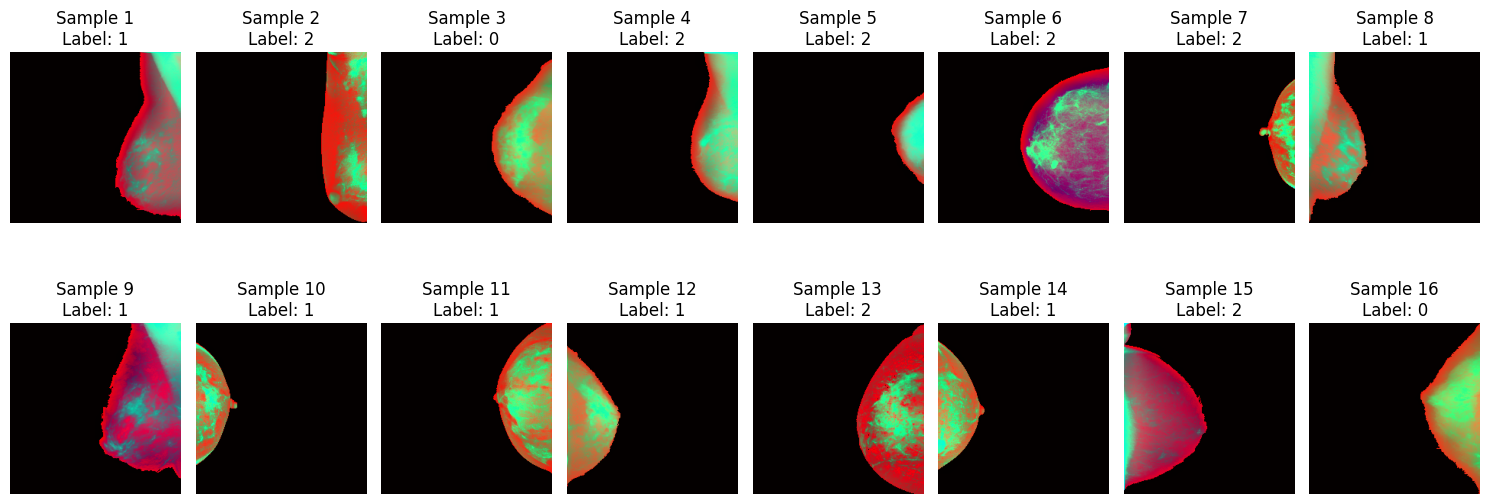

In [13]:
def check_import(test_images, test_labels, num_ex):
    """
    Mostra una selecció d'imatges amb les seves etiquetes corresponents per comprovar el preprocessat.

    Args:
    - test_images (array): Array que conté les imatges a visualitzar.
    - test_labels (array): Array que conté les etiquetes corresponents a les imatges.
    - num_ex (int): Nombre d'imatges a visualitzar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """

    num_rows = (num_ex + 7) // 8
    fig, axes = plt.subplots(num_rows, 8, figsize=(15, num_rows * 3))

    for i in range(num_ex):
        row = i // 8
        col = i % 8
        axes[row, col].imshow(test_images[i])
        axes[row, col].set_title(f"Sample {i+1}\nLabel: {test_labels[i]}")
        axes[row, col].axis('off')

    for i in range(num_ex, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

check_import(test_images, test_labels, 16)

### UTILS


In [14]:
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, test_ds):
    """
    Avalua un model utilitzant un conjunt de dades de prova i retorna les prediccions i les imatges.

    Args:
    - model: Model a avaluar.
    - test_ds: Conjunt de dades de prova.

    Returns:
    - y_true: Etiquetes reals del conjunt de dades de prova.
    - y_pred: Prediccions del model.
    - imatges_array: Array que conté les imatges utilitzades per a la predicció.
    """
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred


def plot_sample_images(train_ds, num_samples=9):
    """
    Mostra una mostra d'imatges amb les seves etiquetes corresponents.

    Args:
    - train_ds (tf.data.Dataset): Dataset d'entrenament que conté les imatges i les seves etiquetes.
    - num_samples (int): Nombre d'imatges a mostrar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(min(num_samples, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(labels[i].numpy()))
            plt.axis("off")
            height, width, channels = images[i].shape
            pixel_range = (np.min(images[i]), np.max(images[i]))


def replicate_augmented_images(train_ds, model_augmentation, num_replications=4):
    """
    Reprodueix una imatge aleatòria del conjunt de dades d'entrenament múltiples vegades amb augmentació.

    Args:
    - train_ds (tf.data.Dataset): Dataset d'entrenament que conté les imatges.
    - model_augmentation (tf.keras.Sequential): Model d'augmentació que s'aplicarà a la imatge.
    - num_replications (int): Nombre de vegades que es vol replicar la imatge amb augmentació.

    Returns:
    - No retorna cap valor, només mostra les imatges amb augmentació.
    """
    for images, _ in train_ds.take(1):
        sample_image = images[0]

    augmented_images = [model_augmentation(tf.expand_dims(sample_image, 0)) for _ in range(num_replications)]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, num_replications + 1, 1)
    plt.title('Imatge original')
    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.axis("off")

    for i, augmented_image in enumerate(augmented_images):
        plt.subplot(1, num_replications + 1, i + 2)
        plt.title(f'Imatge amb augmentació {i+1}')
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

    plt.show()


## Creem els tensors de tensorflow a partir dels arrays

In [15]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Comprovem algunes imatges del tensor d'entrenament amb les seves etiquetes

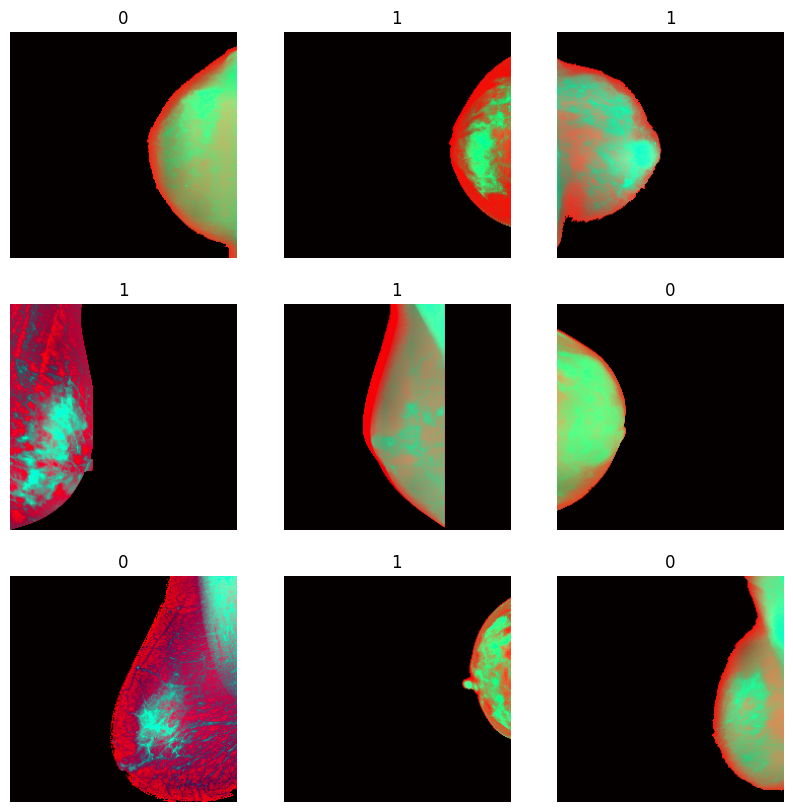

In [10]:
plot_sample_images(train_ds, num_samples=9)

## Augment de dades
Tot i que després ho utilitzarem dins del ModelGenerator, comprovem quines modificacions d'augmentació són acceptables

In [11]:
model_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    #RandomRotation(0.1),
    #RandomZoom(0.1),
    RandomContrast(0.1)
])

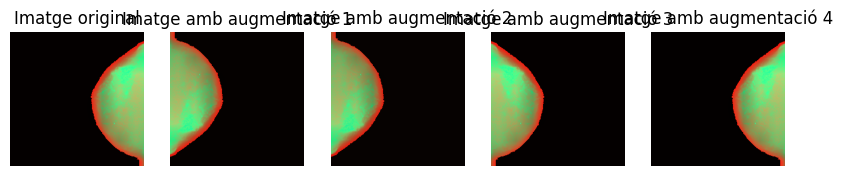

In [12]:
replicate_augmented_images(train_ds, model_augmentation, num_replications=4)

He descartat altres mètodes d'augment com rotació i zoom per donar resultats aberrants. A tall d'exemple:

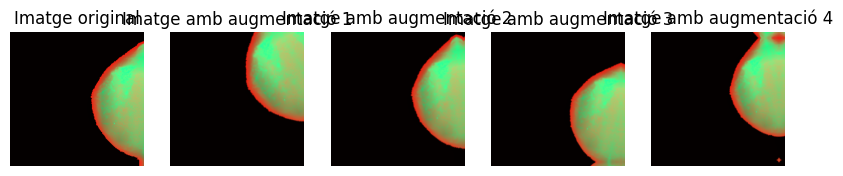

In [13]:
model_augmentation2 = Sequential([
    #RandomFlip("horizontal"),
    #RandomFlip("vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    #RandomContrast(0.1)
])
replicate_augmented_images(train_ds, model_augmentation2, num_replications=4)

# Custom Model

**En aquest primer punt crearem una classe per construir i evaluar els models creats. Crearem una estructura simple amb una primera capa de Flatten/ Globalaveragepooling2D, seguida de x capes ocultes i una capa de dropout per cada una. Per acabar, una capa de sortida amb 3 neurones**

In [14]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from tensorflow.keras.applications.imagenet_utils import preprocess_input as preprocess_input_default

class CustomModel:
    def __init__(self, input_shape = (224,224,3), train_data = train_ds, val_data = val_ds, test_data = test_ds, pretrained_model=None, hidden_layers=None, dropout=None, pooling='flatten', weights='imagenet', num_outputs=3, model_augmentation=True):
        """
        Inicialitza una instància de la classe CustomModel per generar un model de xarxa neuronal convolucional (CNN) amb opcions per pre-entrenar i personalitzar les capes ocultes.

        Args:
        - input_shape (tuple): Dimensions de la imatge d'entrada (ex: (224, 224, 3)).
        - pretrained_model (str or None): Model pre-entrenat a utilitzar (opcions: 'inception', 'efficientnetb2', 'vgg19' o None per cap capa pre-entrenada).
        - hidden_layers (list or None): Llista de dimensions per les capes ocultes (ex: [126, 64, 32]) o None per cap capa oculta.
        - dropout (list or None): Llista de valors de dropout per a cada capa oculta o None per cap dropout.
        - pooling (str): Tipus de capa de pooling ('flatten' o 'globalaverage').
        - weights (str): Pesos inicials del model ('imagenet' o None).
        - num_outputs (int): Nombre de neurones a la capa de sortida.
        - trainable (bool): Indica si es permet re-entrenar les capes (True) o no (False).
        - trainable_layers (list or None): Llista de noms de les capes a re-entrenar o None per re-entrenar totes les capes.
        - model_augmentation (bool): Indica si es vol utilitzar data augmentació (True) o no (False).
        """
        self.input_shape = input_shape
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.pretrained_model = pretrained_model
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.pooling = pooling
        self.weights = weights
        self.num_outputs = num_outputs
        self.model_augmentation = model_augmentation

        self.pretrained_model_options = {
            'inception': tf.keras.applications.InceptionV3,
            'efficientnetb2': tf.keras.applications.EfficientNetB2,
            'vgg19': tf.keras.applications.VGG19,
            'none': None
        }

        self.pooling_options = {
            'flatten': Flatten,
            'globalaverage': GlobalAveragePooling2D
        }

    def generate_model(cls):
      # Selecció del model pre-entrenat
      base_model_class = cls.pretrained_model_options.get(cls.pretrained_model)
      base_model = None
      preprocess_input = preprocess_input_default

      if base_model_class:
          base_model = base_model_class(input_shape=cls.input_shape, include_top=False, weights=cls.weights)
          for layer in base_model.layers:
              layer.trainable = False
          if cls.pretrained_model == 'inception':
              preprocess_input = tf.keras.applications.inception_v3.preprocess_input
          elif cls.pretrained_model == 'efficientnetb2':
              preprocess_input = tf.keras.applications.efficientnet.preprocess_input
          elif cls.pretrained_model == 'vgg19':
              preprocess_input = tf.keras.applications.vgg19.preprocess_input

      # Construcció del model base
      scratch_model = [Conv2D(16, (3, 3), activation='relu', input_shape=cls.input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),]

      # Selecció de la capa de pooling
      pool_layer_class = cls.pooling_options.get(cls.pooling)
      pool_layer = None
      if pool_layer_class:
          pool_layer = pool_layer_class()

      # Construcció de les capes ocultes
      hidden_layers_list = []
      if cls.hidden_layers:
          hidden_layers_list.append(pool_layer)
          for units, drop_rate in zip(cls.hidden_layers, cls.dropout):
              hidden_layers_list.append(Dense(units, activation='relu'))
              if drop_rate:
                  hidden_layers_list.append(Dropout(drop_rate))
      else:
          hidden_layers_list = [pool_layer]

      # Construcció del model complet
      if base_model:
          if cls.model_augmentation:
              model_augmentation = tf.keras.Sequential([
                  RandomFlip("horizontal"),
                  RandomFlip("vertical"),
                  RandomContrast(0.1)
              ])
              model = Sequential([model_augmentation] + [Lambda(preprocess_input)] + [base_model] + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
          else:
              model = Sequential([Lambda(preprocess_input)] + [base_model] + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
      else:
          if cls.model_augmentation:
              model_augmentation = tf.keras.Sequential([
                  RandomFlip("horizontal"),
                  RandomFlip("vertical"),
                  RandomContrast(0.1)
              ])
              model = Sequential([model_augmentation] + [Lambda(preprocess_input)] + scratch_model +  hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
          else:
              model = Sequential([Lambda(preprocess_input)] + scratch_model + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])

      model.build((None, *cls.input_shape))

      return model

    def show_layers(self, model):
        for i, layer in enumerate(model.layers):
            print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")


    def train(self, model, optimizer = Adam(learning_rate=1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], epochs = 50, callbacks=None):
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        history = model.fit(self.train_data, epochs=epochs, validation_data=self.val_data, callbacks=callbacks)
        return history

    def full_report(self, model, history):

        plot_metrics(history)

        y_true, y_pred = evaluate_model(model, self.test_data)

        plot_confusion_matrix(y_true, y_pred, ('Normal', 'Benign', 'Malignant'))

        print(classification_report(y_true, y_pred))

        loss, accuracy = model.evaluate(self.test_data)

        print(f'Pèrdua en el conjunt de dades de test: {loss}')
        print(f'Precisió en el conjunt de dades de test: {accuracy}')

    def freeze_layers(self, model_initial, num_layers_to_freeze):
        for layer in model_initial.layers[2].layers[:num_layers_to_freeze]:
            layer.trainable = False
        for layer in model_initial.layers[2].layers[num_layers_to_freeze:]:
            layer.trainable = True
        return model_initial

results_path = '/content/drive/My Drive'


# 0. Model from scratch

## 0.1 Creem el model i l'entrenem

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                 

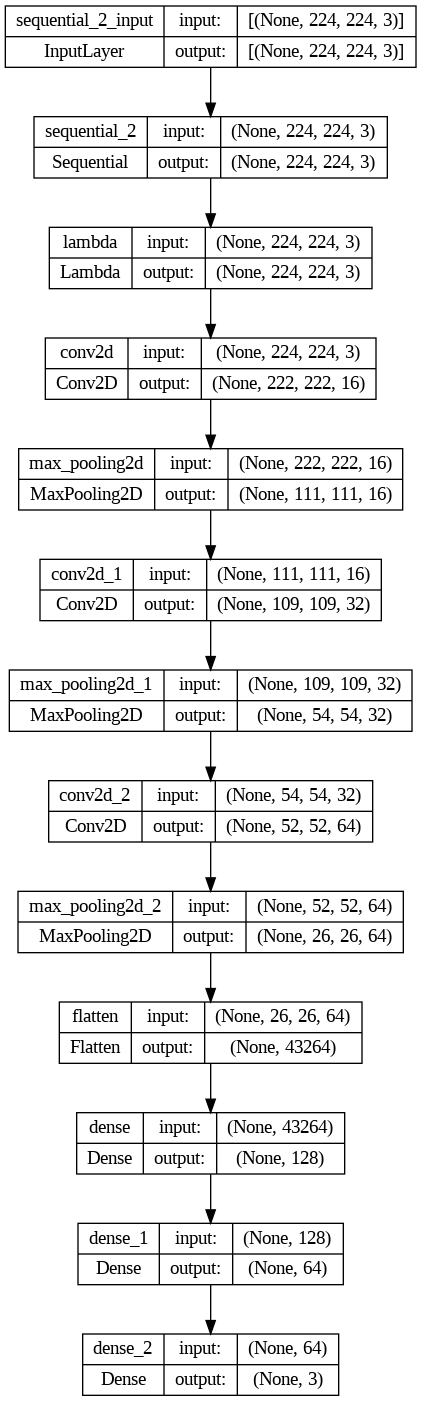

In [15]:
custom_model0 = CustomModel(pretrained_model=None, hidden_layers=[128, 64], dropout=[0.0, 0.0], pooling='flatten')
model_0 = custom_model0.generate_model()
model_0.summary()

from keras.utils import plot_model

plot_model(model_0, to_file='model_plot0.png', show_shapes=True, show_layer_names=True)


In [16]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model_0, legend=True)
visualkeras.layered_view(model_0, legend=True).save('model_visualization.png')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.5 MB/s eta 0:00:00


In [17]:
checkpoint_callback = ModelCheckpoint(results_path + '/model_0.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)
optimizer = Adam(learning_rate=1e-3)

history0 = custom_model0.train(model=model_0, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, checkpoint_callback, reduce_lr])

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 5.4950 - accuracy: 0.4357
Epoch 1: val_loss improved from inf to 0.99492, saving model to /content/drive/My Drive/model_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 10s 40ms/step - loss: 5.4950 - accuracy: 0.4357 - val_loss: 0.9949 - val_accuracy: 0.4407 - lr: 0.0010
Epoch 2/100
115/116 [============================>.] - ETA: 0s - loss: 0.9695 - accuracy: 0.5052
Epoch 2: val_loss improved from 0.99492 to 0.94499, saving model to /content/drive/My Drive/model_0.h5
116/116 [==============================] - 3s 30ms/step - loss: 0.9698 - accuracy: 0.5050 - val_loss: 0.9450 - val_accuracy: 0.5189 - lr: 0.0010
Epoch 3/100
115/116 [============================>.] - ETA: 0s - loss: 0.9191 - accuracy: 0.5391
Epoch 3: val_loss did not improve from 0.94499
116/116 [==============================] - 3s 28ms/step - loss: 0.9192 - accuracy: 0.5386 - val_loss: 0.9554 - val_accuracy: 0.5253 - lr: 0.0010
Epoch 4/100
115/116 [============================>.] - ETA: 0s - loss: 0.8988 - accuracy: 0.5663
Epoch 4: val_loss improved from 0.94499 to 0.93722, saving model to /content/drive/My Drive/model_0.h5
116/116 [===========

## 0.2. Mostrem els resultats

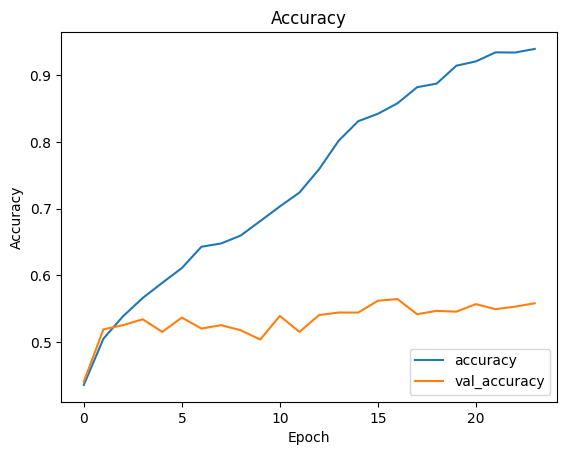

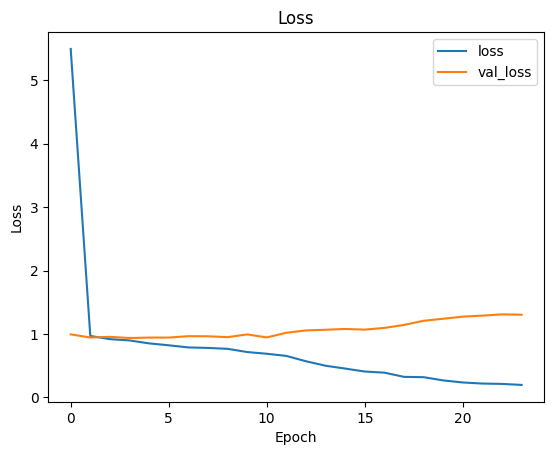

1/1 [==============================] - 0s 99ms/step


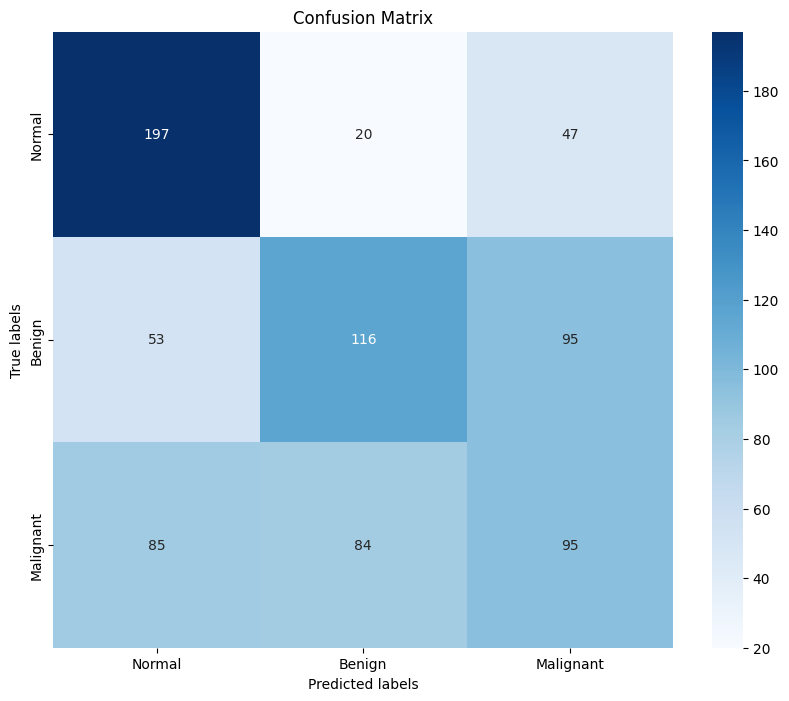

              precision    recall  f1-score   support

           0       0.59      0.75      0.66       264
           1       0.53      0.44      0.48       264
           2       0.40      0.36      0.38       264

    accuracy                           0.52       792
   macro avg       0.51      0.52      0.51       792
weighted avg       0.51      0.52      0.51       792

25/25 [==============================] - 0s 11ms/step - loss: 0.9378 - accuracy: 0.5152
Pèrdua en el conjunt de dades de test: 0.9378451704978943
Precisió en el conjunt de dades de test: 0.5151515007019043


In [18]:
custom_model0.full_report(model=model_0, history=history0)


# 1. Model InceptionV3

## 1.1. Creem el model i entrenem

In [19]:
custom_model = CustomModel(pretrained_model='inception', hidden_layers=[16, 16, 144], dropout=[0.0, 0.1, 0.4], pooling='globalaverage')
model_inception = custom_model.generate_model()
model_inception.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 16)                32784     
                                                                 
 dense_4 (Dense)             (None, 16)                

In [20]:
optimizer = Adam(learning_rate=1e-3)
checkpoint_callback = ModelCheckpoint(results_path + '/model_inception0.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)

history = custom_model.train(model=model_inception, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, reduce_lr, checkpoint_callback])

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.4148
Epoch 1: val_loss improved from inf to 1.00069, saving model to /content/drive/My Drive/model_inception0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 26s 140ms/step - loss: 1.0642 - accuracy: 0.4148 - val_loss: 1.0007 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 2/100
115/116 [============================>.] - ETA: 0s - loss: 0.9946 - accuracy: 0.4726
Epoch 2: val_loss improved from 1.00069 to 0.97158, saving model to /content/drive/My Drive/model_inception0.h5
116/116 [==============================] - 12s 101ms/step - loss: 0.9956 - accuracy: 0.4717 - val_loss: 0.9716 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 3/100
115/116 [============================>.] - ETA: 0s - loss: 0.9491 - accuracy: 0.5147
Epoch 3: val_loss improved from 0.97158 to 0.96244, saving model to /content/drive/My Drive/model_inception0.h5
116/116 [==============================] - 11s 91ms/step - loss: 0.9496 - accuracy: 0.5139 - val_loss: 0.9624 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 4/100
115/116 [============================>.] - ETA: 0s - loss: 0.9514 - accuracy: 0.5109
Epoch 4: val_loss improved from 0.96244 to 0.

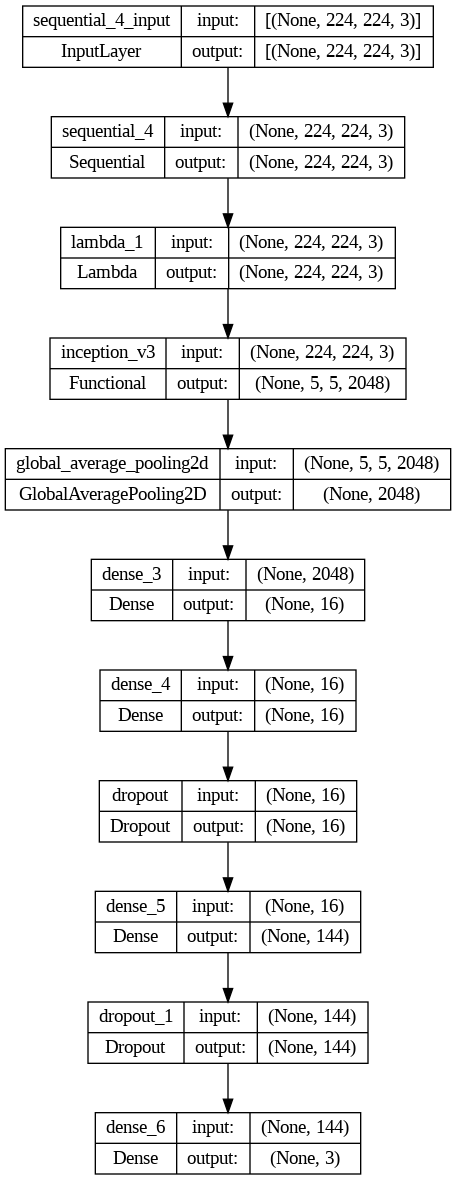

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model_inception, to_file='model_inception.png', show_shapes=True, show_layer_names=True)

## 1.2. Avaluem els resultats

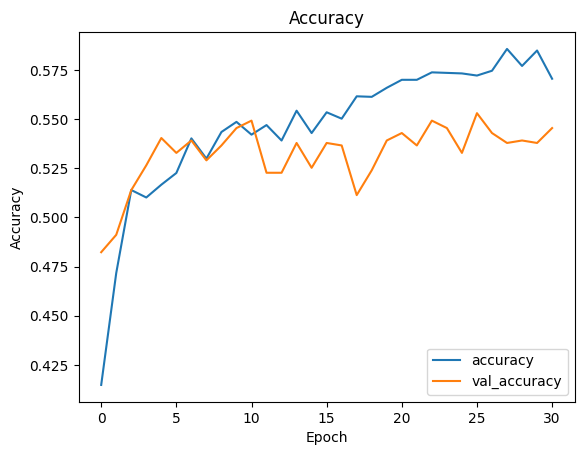

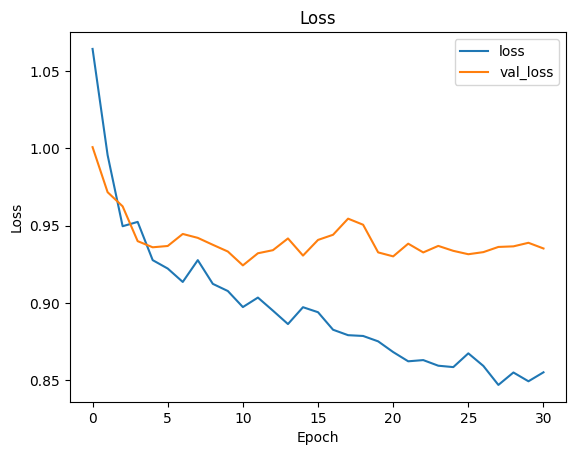

1/1 [==============================] - 1s 1s/step


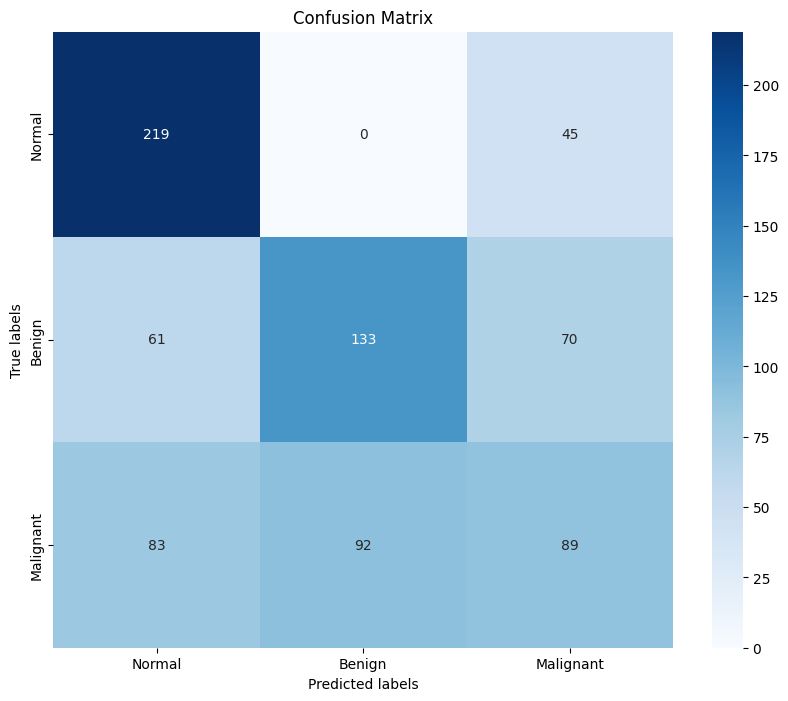

              precision    recall  f1-score   support

           0       0.60      0.83      0.70       264
           1       0.59      0.50      0.54       264
           2       0.44      0.34      0.38       264

    accuracy                           0.56       792
   macro avg       0.54      0.56      0.54       792
weighted avg       0.54      0.56      0.54       792

25/25 [==============================] - 2s 64ms/step - loss: 0.8808 - accuracy: 0.5568
Pèrdua en el conjunt de dades de test: 0.8808209896087646
Precisió en el conjunt de dades de test: 0.5568181872367859


In [22]:
custom_model.full_report(model_inception, history)

## 1.3. Observem les capes del model base

In [23]:
custom_model.show_layers(model_inception.layers[2])

Layer 0: input_1 - Trainable: False
Layer 1: conv2d_3 - Trainable: False
Layer 2: batch_normalization - Trainable: False
Layer 3: activation - Trainable: False
Layer 4: conv2d_4 - Trainable: False
Layer 5: batch_normalization_1 - Trainable: False
Layer 6: activation_1 - Trainable: False
Layer 7: conv2d_5 - Trainable: False
Layer 8: batch_normalization_2 - Trainable: False
Layer 9: activation_2 - Trainable: False
Layer 10: max_pooling2d_3 - Trainable: False
Layer 11: conv2d_6 - Trainable: False
Layer 12: batch_normalization_3 - Trainable: False
Layer 13: activation_3 - Trainable: False
Layer 14: conv2d_7 - Trainable: False
Layer 15: batch_normalization_4 - Trainable: False
Layer 16: activation_4 - Trainable: False
Layer 17: max_pooling2d_4 - Trainable: False
Layer 18: conv2d_11 - Trainable: False
Layer 19: batch_normalization_8 - Trainable: False
Layer 20: activation_8 - Trainable: False
Layer 21: conv2d_9 - Trainable: False
Layer 22: conv2d_12 - Trainable: False
Layer 23: batch_normali

## 1.5. Descongelem l'últim bloc

In [24]:
checkpoint_callback = ModelCheckpoint(results_path + '/model_inception1.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-5)

inception_retrained1 = custom_model.freeze_layers(model_initial=model_inception, num_layers_to_freeze = 275)
history2 = custom_model.train(model=inception_retrained1, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])
custom_model.show_layers(inception_retrained1.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.9147 - accuracy: 0.5383
Epoch 1: val_loss improved from inf to 0.92987, saving model to /content/drive/My Drive/model_inception1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 40s 269ms/step - loss: 0.9147 - accuracy: 0.5383 - val_loss: 0.9299 - val_accuracy: 0.5366
Epoch 2/50
115/116 [============================>.] - ETA: 0s - loss: 0.8853 - accuracy: 0.5562
Epoch 2: val_loss improved from 0.92987 to 0.92173, saving model to /content/drive/My Drive/model_inception1.h5
116/116 [==============================] - 11s 99ms/step - loss: 0.8862 - accuracy: 0.5556 - val_loss: 0.9217 - val_accuracy: 0.5328
Epoch 3/50
115/116 [============================>.] - ETA: 0s - loss: 0.8806 - accuracy: 0.5668
Epoch 3: val_loss improved from 0.92173 to 0.91534, saving model to /content/drive/My Drive/model_inception1.h5
116/116 [==============================] - 12s 101ms/step - loss: 0.8814 - accuracy: 0.5665 - val_loss: 0.9153 - val_accuracy: 0.5442
Epoch 4/50
115/116 [============================>.] - ETA: 0s - loss: 0.8666 - accuracy: 0.5701
Epoch 4: val_loss did not improve from 0.91534
116/116 [==============================]

### Avaluem resultats

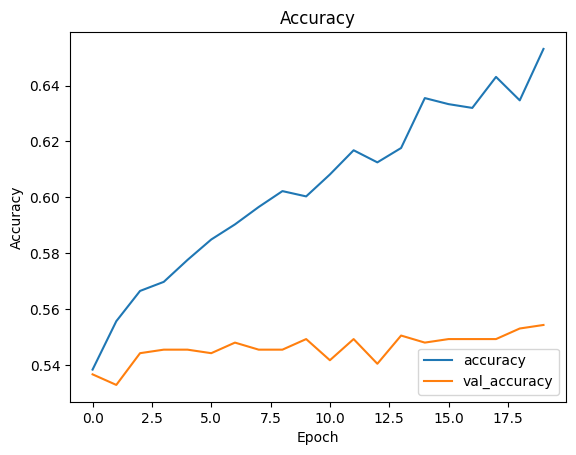

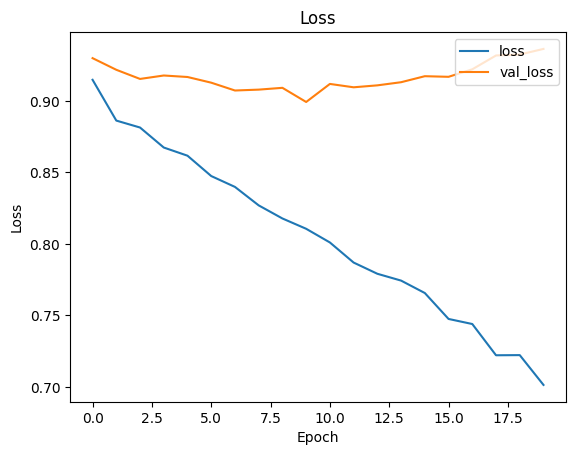

1/1 [==============================] - 1s 1s/step


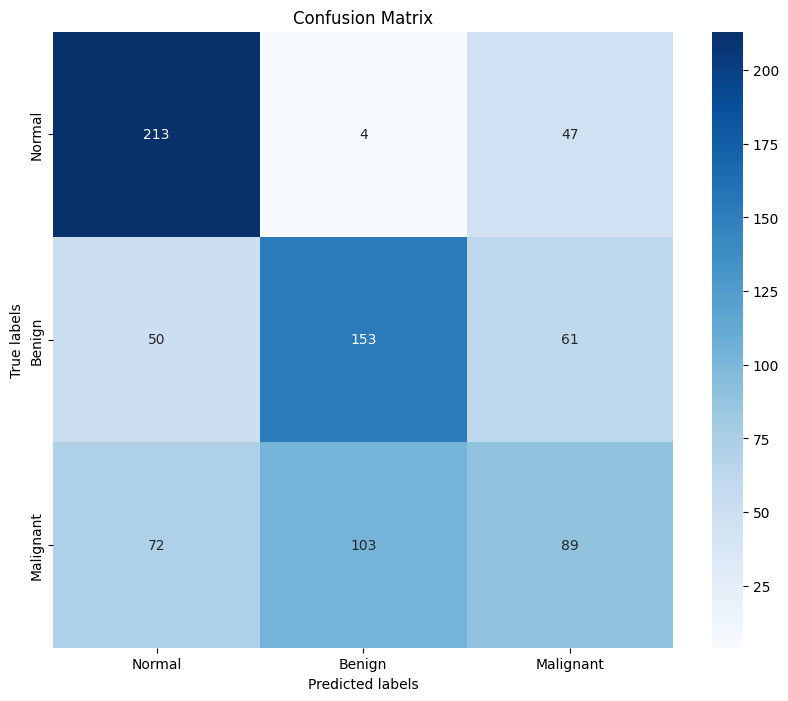

              precision    recall  f1-score   support

           0       0.64      0.81      0.71       264
           1       0.59      0.58      0.58       264
           2       0.45      0.34      0.39       264

    accuracy                           0.57       792
   macro avg       0.56      0.57      0.56       792
weighted avg       0.56      0.57      0.56       792

25/25 [==============================] - 2s 64ms/step - loss: 0.8605 - accuracy: 0.5745
Pèrdua en el conjunt de dades de test: 0.8604870438575745
Precisió en el conjunt de dades de test: 0.5744949579238892


In [25]:
custom_model.full_report(model=inception_retrained1, history=history2)

## 1.6. Descongelem els dos últims blocs

In [26]:
checkpoint_callback = ModelCheckpoint(results_path + '/model_inception2.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-5)

inception_retrained2 = custom_model.freeze_layers(model_initial=model_inception, num_layers_to_freeze = 247)
history3 = custom_model.train(model=inception_retrained2, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])
custom_model.show_layers(inception_retrained2.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.5749
Epoch 1: val_loss improved from inf to 0.90055, saving model to /content/drive/My Drive/model_inception2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 46s 310ms/step - loss: 0.8685 - accuracy: 0.5749 - val_loss: 0.9006 - val_accuracy: 0.5480
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.8416 - accuracy: 0.5795
Epoch 2: val_loss improved from 0.90055 to 0.89025, saving model to /content/drive/My Drive/model_inception2.h5
116/116 [==============================] - 13s 110ms/step - loss: 0.8416 - accuracy: 0.5795 - val_loss: 0.8902 - val_accuracy: 0.5530
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.6019
Epoch 3: val_loss did not improve from 0.89025
116/116 [==============================] - 12s 102ms/step - loss: 0.8119 - accuracy: 0.6019 - val_loss: 0.8933 - val_accuracy: 0.5581
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.7945 - accuracy: 0.6112
Epoch 4: val_loss did not improve from 0.89025
116/116 [==============================] - 12s 101ms/step - loss: 0.7945 - accuracy: 0.6112 - val_loss: 

### Avaluem resultats

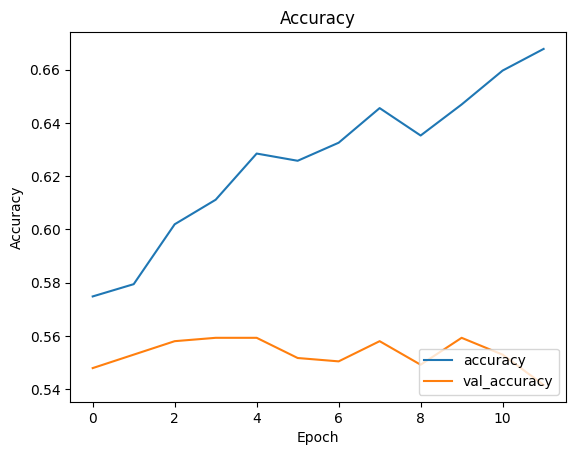

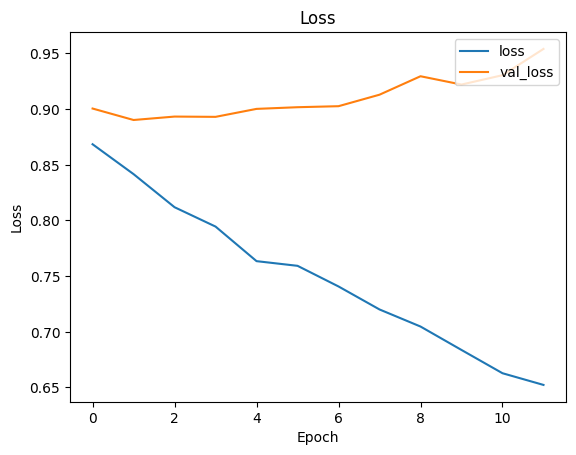

1/1 [==============================] - 1s 1s/step


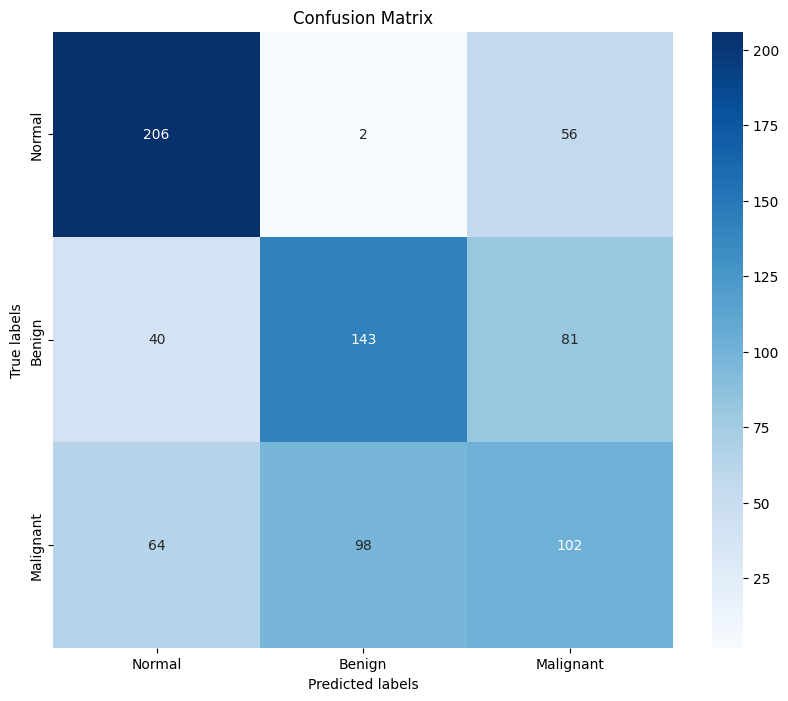

              precision    recall  f1-score   support

           0       0.66      0.78      0.72       264
           1       0.59      0.54      0.56       264
           2       0.43      0.39      0.41       264

    accuracy                           0.57       792
   macro avg       0.56      0.57      0.56       792
weighted avg       0.56      0.57      0.56       792

25/25 [==============================] - 2s 65ms/step - loss: 0.8588 - accuracy: 0.5694
Pèrdua en el conjunt de dades de test: 0.8587935566902161
Precisió en el conjunt de dades de test: 0.5694444179534912


In [27]:
custom_model.full_report(model=inception_retrained2, history=history3)

## 1.7. Descongelem tot el model

In [28]:
checkpoint_callback = ModelCheckpoint(results_path + '/model_inception3.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-5)

inception_retrained3 = custom_model.freeze_layers(model_initial=model_inception, num_layers_to_freeze = 1)
history4 = custom_model.train(model=inception_retrained3, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])
custom_model.show_layers(inception_retrained2.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.5118
Epoch 1: val_loss improved from inf to 0.93040, saving model to /content/drive/My Drive/model_inception3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 104s 608ms/step - loss: 0.9514 - accuracy: 0.5118 - val_loss: 0.9304 - val_accuracy: 0.5290
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.5502
Epoch 2: val_loss improved from 0.93040 to 0.92534, saving model to /content/drive/My Drive/model_inception3.h5
116/116 [==============================] - 32s 278ms/step - loss: 0.8959 - accuracy: 0.5502 - val_loss: 0.9253 - val_accuracy: 0.5316
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8661 - accuracy: 0.5738
Epoch 3: val_loss improved from 0.92534 to 0.90824, saving model to /content/drive/My Drive/model_inception3.h5
116/116 [==============================] - 32s 275ms/step - loss: 0.8661 - accuracy: 0.5738 - val_loss: 0.9082 - val_accuracy: 0.5518
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.8375 - accuracy: 0.5825
Epoch 4: val_loss did not improve from 0.90824
116/116 [=============================

### Avaluem resultats

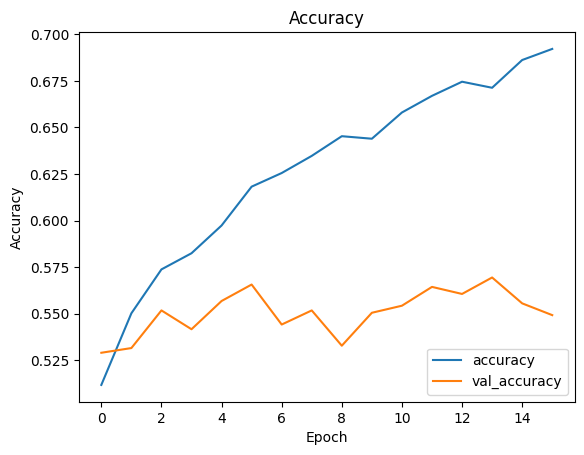

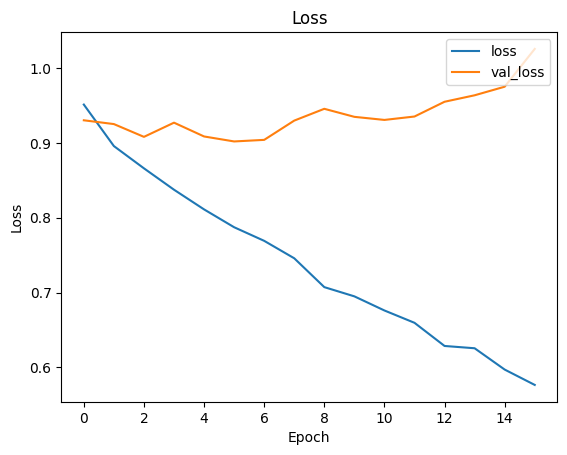

1/1 [==============================] - 1s 1s/step


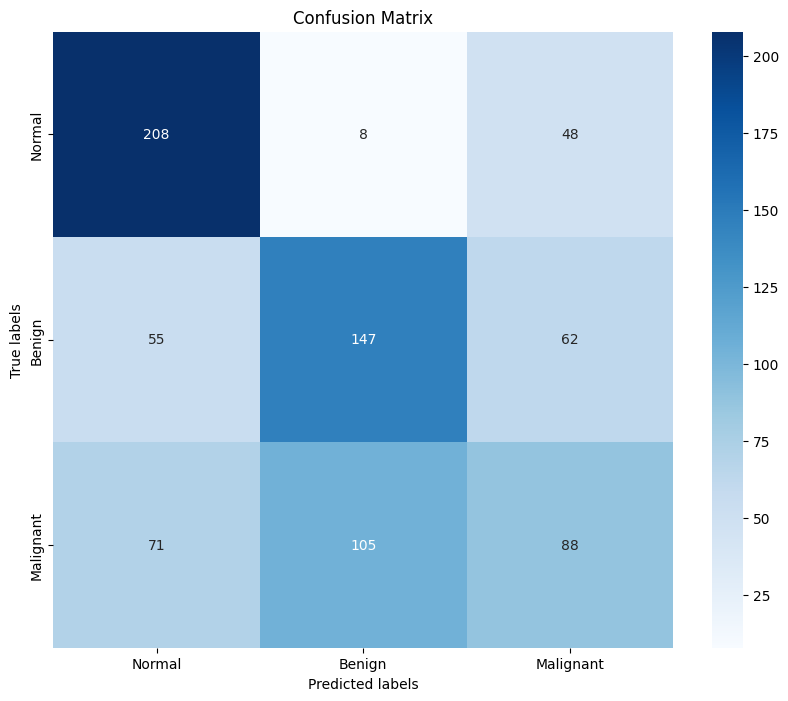

              precision    recall  f1-score   support

           0       0.62      0.79      0.70       264
           1       0.57      0.56      0.56       264
           2       0.44      0.33      0.38       264

    accuracy                           0.56       792
   macro avg       0.54      0.56      0.55       792
weighted avg       0.54      0.56      0.55       792

25/25 [==============================] - 2s 64ms/step - loss: 0.8720 - accuracy: 0.5593
Pèrdua en el conjunt de dades de test: 0.8720213174819946
Precisió en el conjunt de dades de test: 0.5593434572219849


In [29]:
custom_model.full_report(model=inception_retrained3, history=history4)

# 2. Model VGG19

## 2.1. Creem el model i entrenem

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 1680)              42149520  
                                                                 
 dropout_2 (Dropout)         (None, 1680)              0         
                                                       

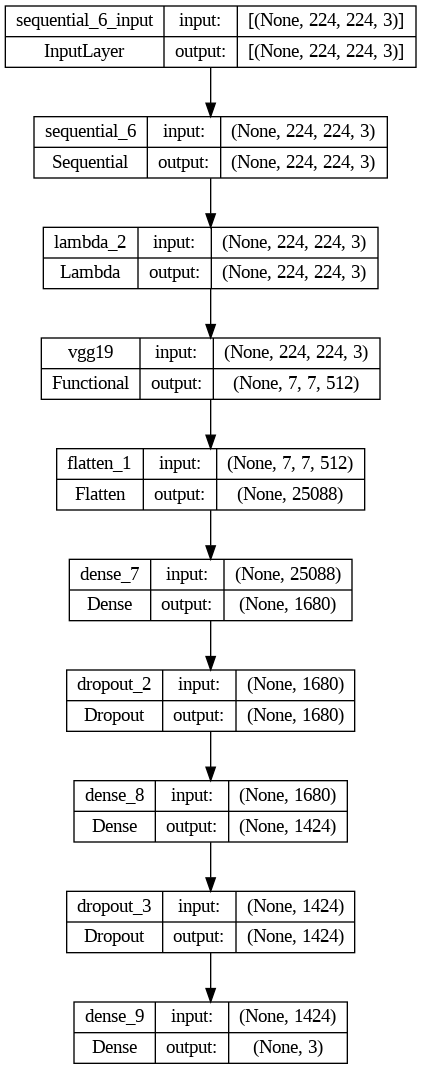

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_vgg19.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-3)

custom_model2 = CustomModel(pretrained_model='vgg19', hidden_layers=[1680, 1424], dropout=[0.2, 0.4], pooling='flatten')
model_vgg19 = custom_model2.generate_model()
model_vgg19.summary()

plot_model(model_vgg19, to_file='model_vgg19.png', show_shapes=True, show_layer_names=True)


In [31]:
history5 = custom_model2.train(model=model_vgg19, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, reduce_lr, checkpoint_callback])


Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 10.2793 - accuracy: 0.4186
Epoch 1: val_loss improved from inf to 1.60299, saving model to /content/drive/My Drive/model_vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 41s 281ms/step - loss: 10.2793 - accuracy: 0.4186 - val_loss: 1.6030 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 1.6555 - accuracy: 0.4582
Epoch 2: val_loss improved from 1.60299 to 1.15268, saving model to /content/drive/My Drive/model_vgg19.h5
116/116 [==============================] - 23s 202ms/step - loss: 1.6555 - accuracy: 0.4582 - val_loss: 1.1527 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 1.2470 - accuracy: 0.4717
Epoch 3: val_loss improved from 1.15268 to 1.00659, saving model to /content/drive/My Drive/model_vgg19.h5
116/116 [==============================] - 23s 202ms/step - loss: 1.2470 - accuracy: 0.4717 - val_loss: 1.0066 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 4/100
116/116 [==============================] - ETA: 0s - loss: 1.1437 - accuracy: 0.4774
Epoch 4: val_loss improved from 1.00659 to 1.00059, s

## 2.2. Mostrem els resultats

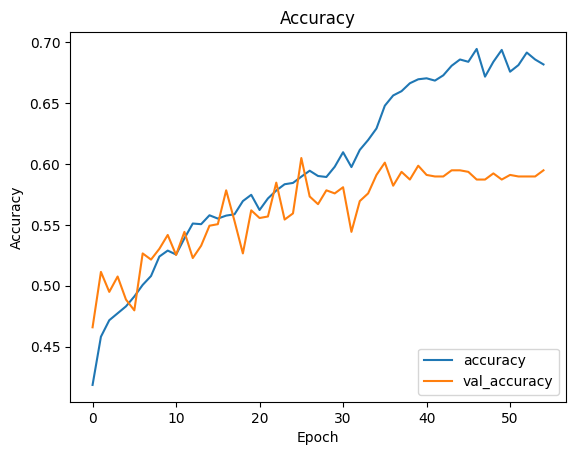

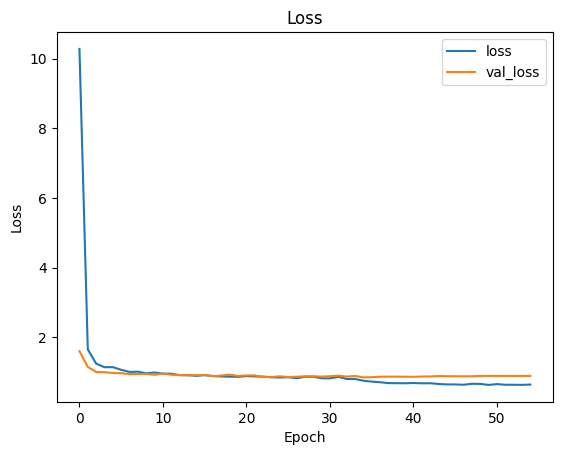

1/1 [==============================] - 0s 184ms/step


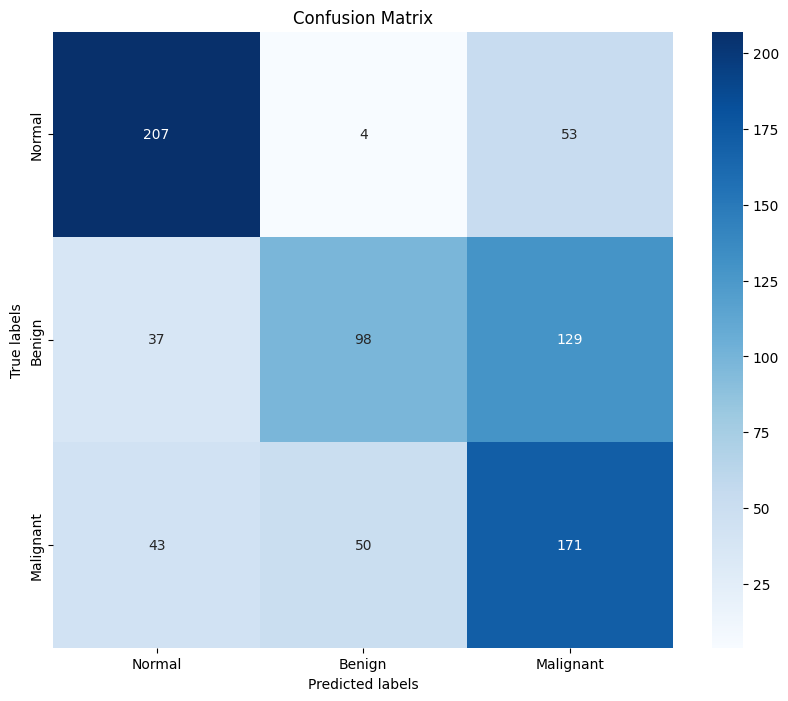

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       264
           1       0.64      0.37      0.47       264
           2       0.48      0.65      0.55       264

    accuracy                           0.60       792
   macro avg       0.62      0.60      0.59       792
weighted avg       0.62      0.60      0.59       792

25/25 [==============================] - 4s 146ms/step - loss: 0.8275 - accuracy: 0.6010
Pèrdua en el conjunt de dades de test: 0.8275071978569031
Precisió en el conjunt de dades de test: 0.6010100841522217


In [32]:
custom_model2.full_report(model=model_vgg19, history=history5)

## 2.3. Observem les capes del model base

In [33]:
custom_model2.show_layers(model_vgg19.layers[2])

Layer 0: input_2 - Trainable: False
Layer 1: block1_conv1 - Trainable: False
Layer 2: block1_conv2 - Trainable: False
Layer 3: block1_pool - Trainable: False
Layer 4: block2_conv1 - Trainable: False
Layer 5: block2_conv2 - Trainable: False
Layer 6: block2_pool - Trainable: False
Layer 7: block3_conv1 - Trainable: False
Layer 8: block3_conv2 - Trainable: False
Layer 9: block3_conv3 - Trainable: False
Layer 10: block3_conv4 - Trainable: False
Layer 11: block3_pool - Trainable: False
Layer 12: block4_conv1 - Trainable: False
Layer 13: block4_conv2 - Trainable: False
Layer 14: block4_conv3 - Trainable: False
Layer 15: block4_conv4 - Trainable: False
Layer 16: block4_pool - Trainable: False
Layer 17: block5_conv1 - Trainable: False
Layer 18: block5_conv2 - Trainable: False
Layer 19: block5_conv3 - Trainable: False
Layer 20: block5_conv4 - Trainable: False
Layer 21: block5_pool - Trainable: False


## 2.4. Congelem les capes fins a la 16 i reentrenem l'últim bloc

In [34]:
model_retrained_vgg1 = custom_model2.freeze_layers(model_initial=model_vgg19, num_layers_to_freeze = 16)

## 2.5. Reentrenem el model amb 50 epcochs més i un lr baix

---



In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_vgg19_1.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-5)

history6 = custom_model2.train(model=model_retrained_vgg1, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])

custom_model2.show_layers(model_retrained_vgg1.layers[2])


Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.6396
Epoch 1: val_loss improved from inf to 0.85921, saving model to /content/drive/My Drive/model_vgg19_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 31s 238ms/step - loss: 0.7442 - accuracy: 0.6396 - val_loss: 0.8592 - val_accuracy: 0.5985
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.6501
Epoch 2: val_loss improved from 0.85921 to 0.84970, saving model to /content/drive/My Drive/model_vgg19_1.h5
116/116 [==============================] - 27s 231ms/step - loss: 0.7141 - accuracy: 0.6501 - val_loss: 0.8497 - val_accuracy: 0.5909
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.6610
Epoch 3: val_loss did not improve from 0.84970
116/116 [==============================] - 25s 212ms/step - loss: 0.6998 - accuracy: 0.6610 - val_loss: 0.8657 - val_accuracy: 0.5896
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.6480
Epoch 4: val_loss did not improve from 0.84970
116/116 [==============================] - 25s 213ms/step - loss: 0.7170 - accuracy: 0.6480 - val_loss: 0.8

### Avaluem resultats

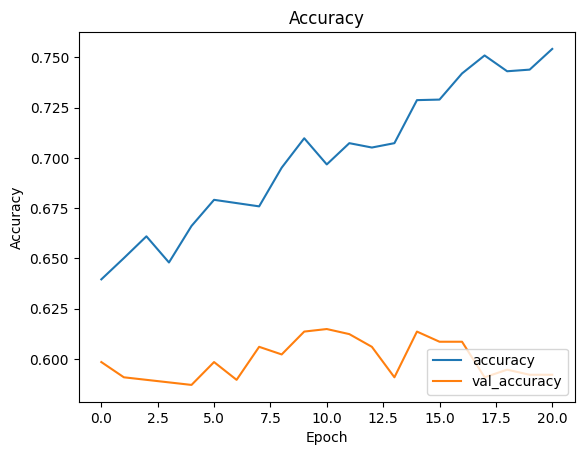

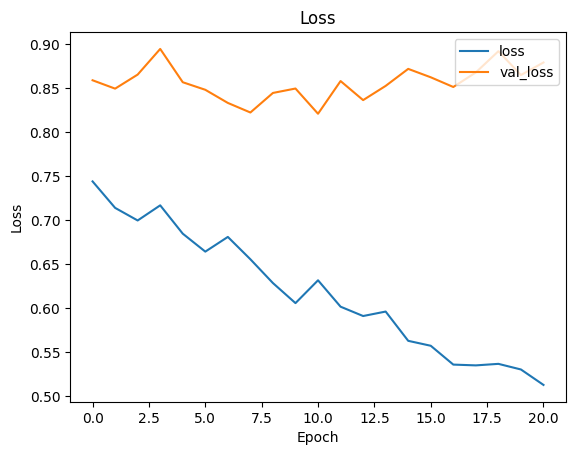

1/1 [==============================] - 0s 180ms/step


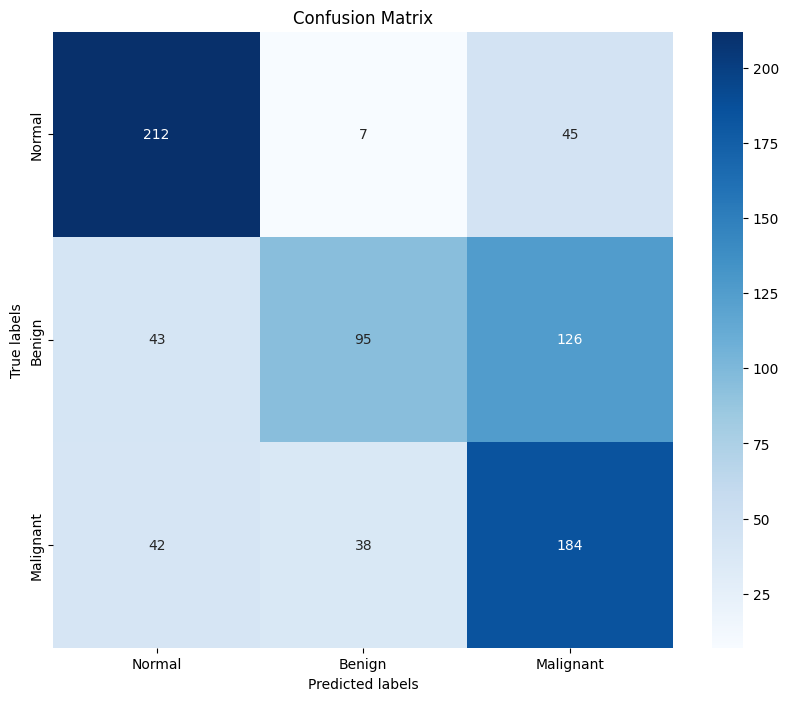

              precision    recall  f1-score   support

           0       0.71      0.80      0.76       264
           1       0.68      0.36      0.47       264
           2       0.52      0.70      0.59       264

    accuracy                           0.62       792
   macro avg       0.64      0.62      0.61       792
weighted avg       0.64      0.62      0.61       792

25/25 [==============================] - 4s 141ms/step - loss: 0.8213 - accuracy: 0.6199
Pèrdua en el conjunt de dades de test: 0.8213251829147339
Precisió en el conjunt de dades de test: 0.6199495196342468


In [36]:
custom_model2.full_report(model=model_retrained_vgg1, history=history6)

## 2.6. Repetim el procediment descongelant els dos últims blocs

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_vgg19_2.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-5)

model_retrained_vgg2 = custom_model2.freeze_layers(model_initial=model_vgg19, num_layers_to_freeze = 11)

history7 = custom_model2.train(model=model_retrained_vgg2, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])

custom_model2.show_layers(model_retrained_vgg2.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.6902
Epoch 1: val_loss improved from inf to 0.86064, saving model to /content/drive/My Drive/model_vgg19_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 54s 421ms/step - loss: 0.6394 - accuracy: 0.6902 - val_loss: 0.8606 - val_accuracy: 0.5985
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.6286 - accuracy: 0.6983
Epoch 2: val_loss did not improve from 0.86064
116/116 [==============================] - 33s 284ms/step - loss: 0.6286 - accuracy: 0.6983 - val_loss: 0.9095 - val_accuracy: 0.5846
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.6989
Epoch 3: val_loss improved from 0.86064 to 0.85380, saving model to /content/drive/My Drive/model_vgg19_2.h5
116/116 [==============================] - 41s 355ms/step - loss: 0.6310 - accuracy: 0.6989 - val_loss: 0.8538 - val_accuracy: 0.6023
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.6902
Epoch 4: val_loss did not improve from 0.85380
116/116 [==============================] - 33s 281ms/step - loss: 0.6303 - accuracy: 0.6902 - val_loss: 0.8

## 2.7. Tornem a mostrar els resultats després del fine tuning

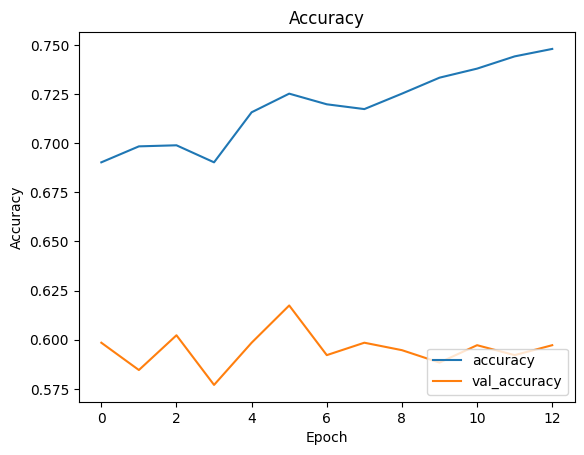

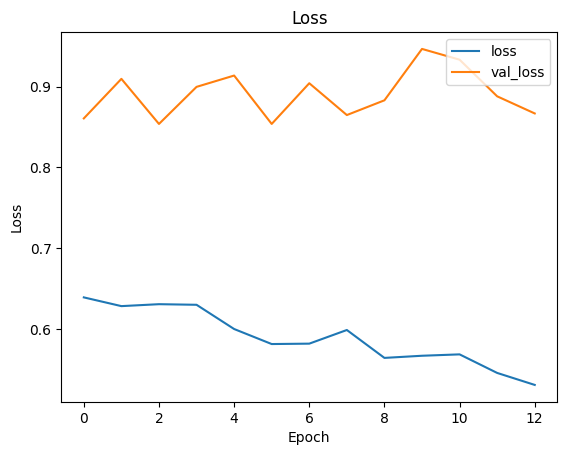

1/1 [==============================] - 0s 173ms/step


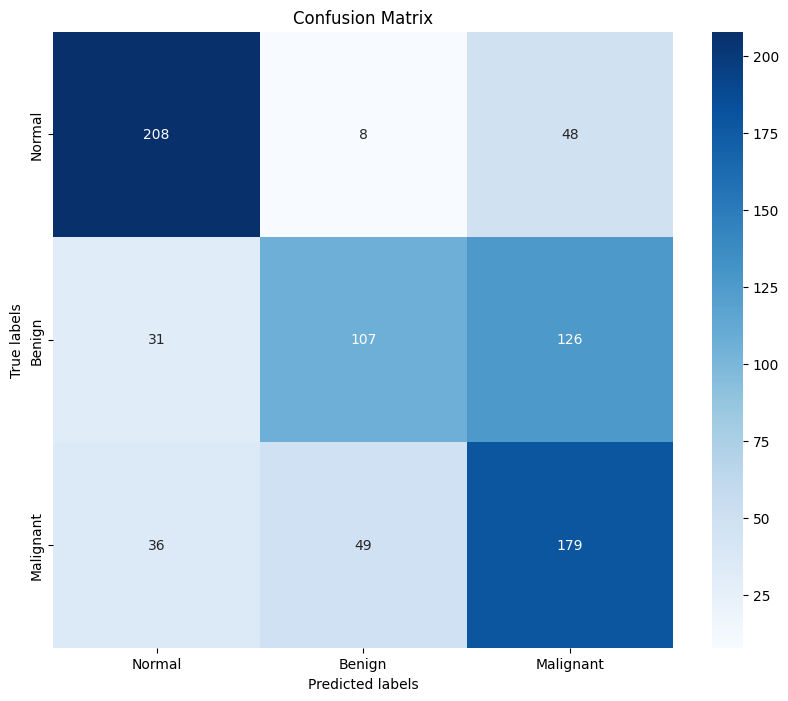

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       264
           1       0.65      0.41      0.50       264
           2       0.51      0.68      0.58       264

    accuracy                           0.62       792
   macro avg       0.64      0.62      0.62       792
weighted avg       0.64      0.62      0.62       792

25/25 [==============================] - 4s 141ms/step - loss: 0.8429 - accuracy: 0.6237
Pèrdua en el conjunt de dades de test: 0.8428972959518433
Precisió en el conjunt de dades de test: 0.6237373948097229


In [38]:
custom_model2.full_report(model=model_retrained_vgg2, history=history7)

## 2.8. Descongelem tot el model

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_vgg19_3.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-5)

model_retrained_vgg3 = custom_model2.freeze_layers(model_initial=model_vgg19, num_layers_to_freeze = 1)

history8 = custom_model2.train(model=model_retrained_vgg3, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])

custom_model2.show_layers(model_retrained_vgg3.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6843
Epoch 1: val_loss improved from inf to 0.84467, saving model to /content/drive/My Drive/model_vgg19_3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 96s 697ms/step - loss: 0.6418 - accuracy: 0.6843 - val_loss: 0.8447 - val_accuracy: 0.6035
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.6954
Epoch 2: val_loss did not improve from 0.84467
116/116 [==============================] - 59s 511ms/step - loss: 0.6238 - accuracy: 0.6954 - val_loss: 0.8629 - val_accuracy: 0.5922
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.6959
Epoch 3: val_loss did not improve from 0.84467
116/116 [==============================] - 59s 505ms/step - loss: 0.6275 - accuracy: 0.6959 - val_loss: 0.8544 - val_accuracy: 0.5997
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7065
Epoch 4: val_loss did not improve from 0.84467
116/116 [==============================] - 59s 508ms/step - loss: 0.6018 - accuracy: 0.7065 - val_loss: 0.8541 - val_accuracy: 0.5972
Epoch 5/50
116/116 [===============

### Avaluem els resultats

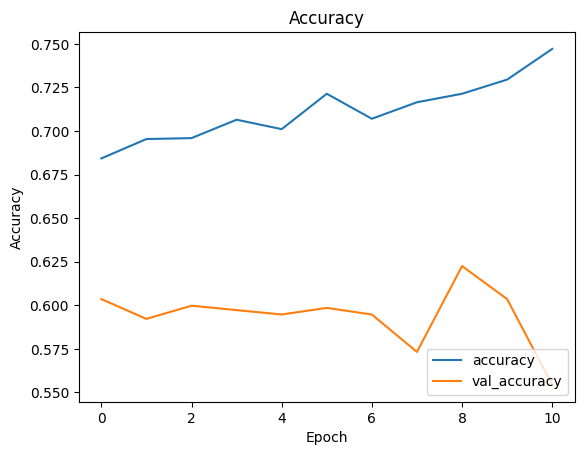

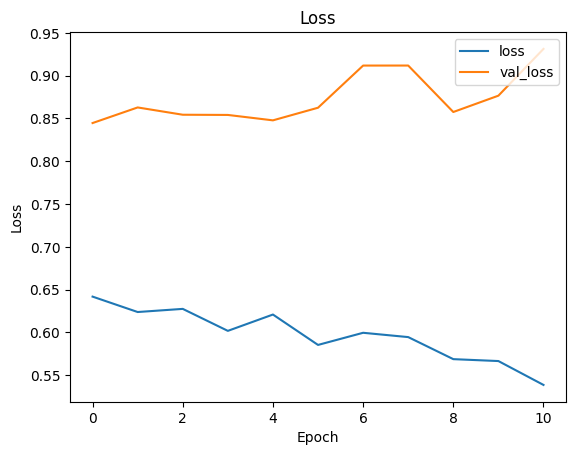

1/1 [==============================] - 0s 182ms/step


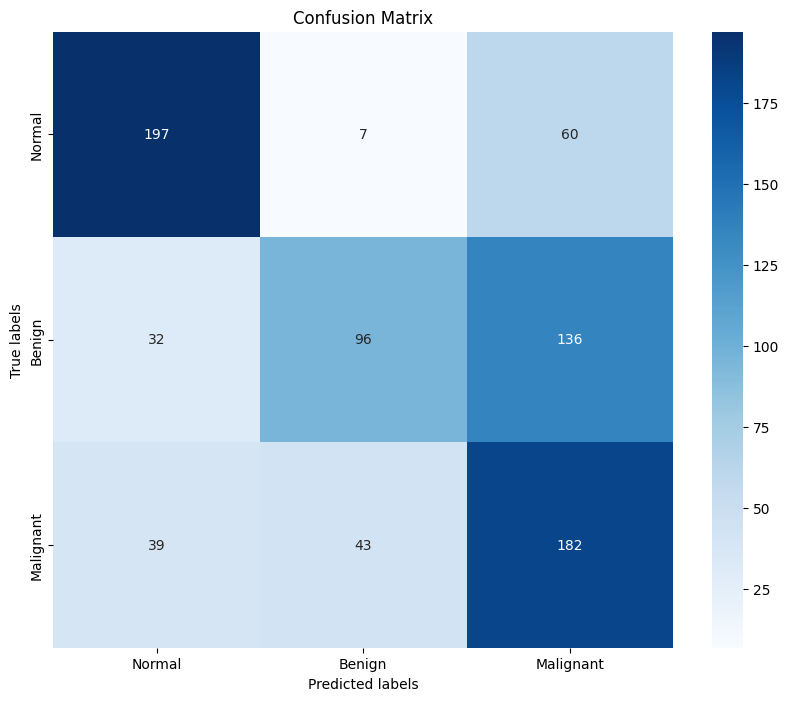

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       264
           1       0.66      0.36      0.47       264
           2       0.48      0.69      0.57       264

    accuracy                           0.60       792
   macro avg       0.62      0.60      0.59       792
weighted avg       0.62      0.60      0.59       792

25/25 [==============================] - 4s 140ms/step - loss: 0.8437 - accuracy: 0.5997
Pèrdua en el conjunt de dades de test: 0.843717634677887
Precisió en el conjunt de dades de test: 0.5997474789619446


In [40]:
custom_model2.full_report(model=model_retrained_vgg3, history=history8)

# 3. Efficientnet B2

## 3.1. Creem el model i entrenem

In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_effic.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-3)

custom_model3 = CustomModel(pretrained_model='efficientnetb2', hidden_layers=[1040, 1040, 1068], dropout=[0.2, 0.3, 0.0], pooling='flatten')
model_effic = custom_model3.generate_model()
model_effic.summary()

history9 = custom_model3.train(model=model_effic, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, reduce_lr, checkpoint_callback])


31790344/31790344 [==============================] - 2s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 68992)             0         
                                                                 
 dense_10 (Dense)            (None, 1040)              71752720  
                                                                 
 dropout_4 (Dropout)         (None, 1040)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 33s 194ms/step - loss: 3.6958 - accuracy: 0.4240 - val_loss: 1.1006 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 1.0942 - accuracy: 0.4779
Epoch 2: val_loss improved from 1.10065 to 0.99309, saving model to /content/drive/My Drive/model_effic.h5
116/116 [==============================] - 17s 149ms/step - loss: 1.0942 - accuracy: 0.4779 - val_loss: 0.9931 - val_accuracy: 0.5227 - lr: 0.0010
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 1.0334 - accuracy: 0.4909
Epoch 3: val_loss improved from 0.99309 to 0.91486, saving model to /content/drive/My Drive/model_effic.h5
116/116 [==============================] - 19s 164ms/step - loss: 1.0334 - accuracy: 0.4909 - val_loss: 0.9149 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 4/100
116/116 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.5185
Epoch 4: val_loss improved from 0.91486 to 0.91104, sa

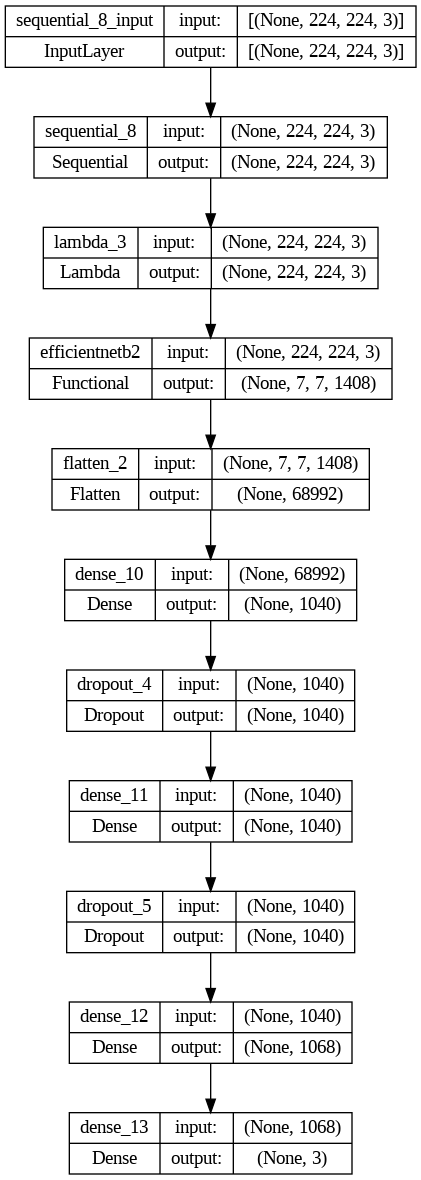

In [42]:
plot_model(model_effic, to_file='model_effic.png', show_shapes=True, show_layer_names=True)

## 3.2. Mostrem els resultats

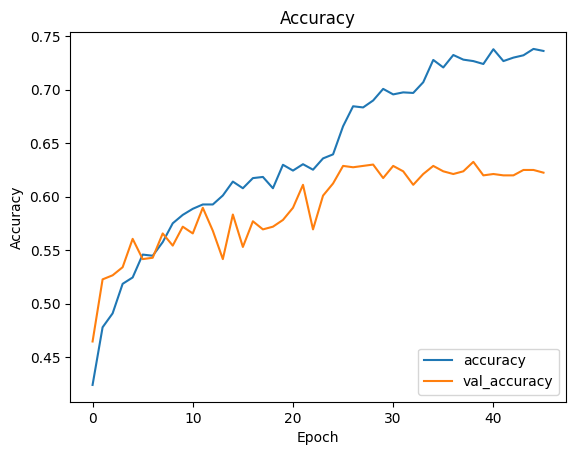

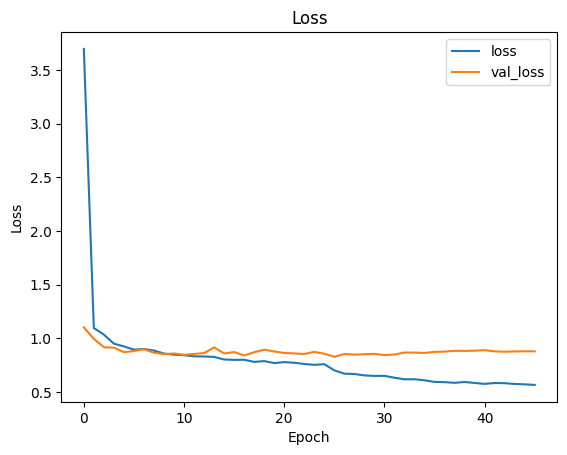

1/1 [==============================] - 2s 2s/step


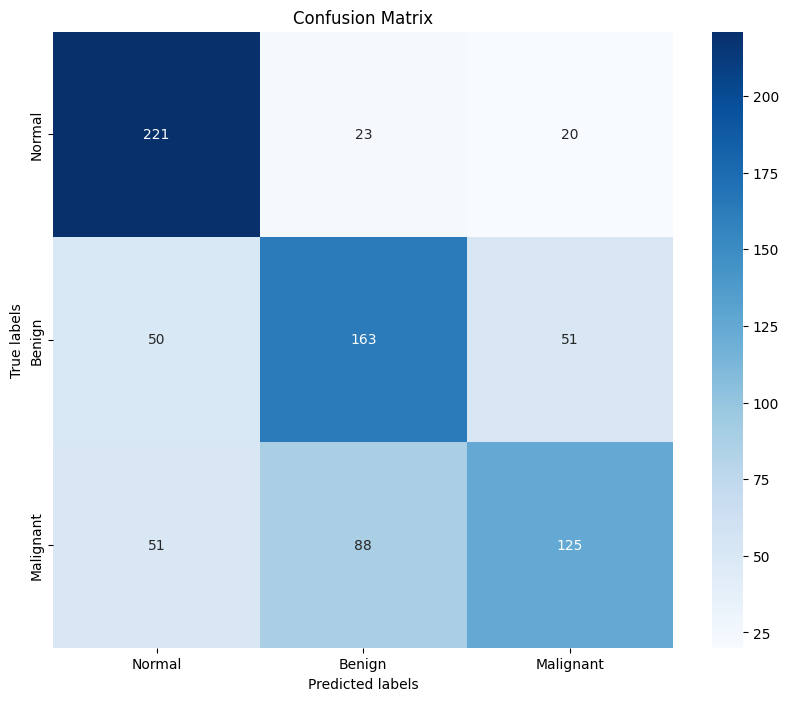

              precision    recall  f1-score   support

           0       0.69      0.84      0.75       264
           1       0.59      0.62      0.61       264
           2       0.64      0.47      0.54       264

    accuracy                           0.64       792
   macro avg       0.64      0.64      0.63       792
weighted avg       0.64      0.64      0.63       792

25/25 [==============================] - 2s 80ms/step - loss: 0.7814 - accuracy: 0.6427
Pèrdua en el conjunt de dades de test: 0.7813704609870911
Precisió en el conjunt de dades de test: 0.6426767706871033


In [43]:
custom_model3.full_report(model=model_effic, history=history9)

## 3.3. Mostrem les capes del model base

In [44]:
custom_model3.show_layers(model_effic.layers[2])

Layer 0: input_3 - Trainable: False
Layer 1: rescaling - Trainable: False
Layer 2: normalization - Trainable: False
Layer 3: rescaling_1 - Trainable: False
Layer 4: stem_conv_pad - Trainable: False
Layer 5: stem_conv - Trainable: False
Layer 6: stem_bn - Trainable: False
Layer 7: stem_activation - Trainable: False
Layer 8: block1a_dwconv - Trainable: False
Layer 9: block1a_bn - Trainable: False
Layer 10: block1a_activation - Trainable: False
Layer 11: block1a_se_squeeze - Trainable: False
Layer 12: block1a_se_reshape - Trainable: False
Layer 13: block1a_se_reduce - Trainable: False
Layer 14: block1a_se_expand - Trainable: False
Layer 15: block1a_se_excite - Trainable: False
Layer 16: block1a_project_conv - Trainable: False
Layer 17: block1a_project_bn - Trainable: False
Layer 18: block1b_dwconv - Trainable: False
Layer 19: block1b_bn - Trainable: False
Layer 20: block1b_activation - Trainable: False
Layer 21: block1b_se_squeeze - Trainable: False
Layer 22: block1b_se_reshape - Trainabl

## 3.4. Descongelem l'últim bloc

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_effic_1.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-3)

model_retrained_effic1 = custom_model3.freeze_layers(model_initial=model_effic, num_layers_to_freeze = 308)

history10 = custom_model3.train(model=model_retrained_effic1, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])

custom_model3.show_layers(model_retrained_effic1.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.9768 - accuracy: 0.5056
Epoch 1: val_loss improved from inf to 1.02779, saving model to /content/drive/My Drive/model_effic_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 59s 388ms/step - loss: 0.9768 - accuracy: 0.5056 - val_loss: 1.0278 - val_accuracy: 0.5682
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.5621
Epoch 2: val_loss improved from 1.02779 to 0.85506, saving model to /content/drive/My Drive/model_effic_1.h5
116/116 [==============================] - 19s 166ms/step - loss: 0.8910 - accuracy: 0.5621 - val_loss: 0.8551 - val_accuracy: 0.5909
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.5876
Epoch 3: val_loss did not improve from 0.85506
116/116 [==============================] - 16s 134ms/step - loss: 0.8326 - accuracy: 0.5876 - val_loss: 1.0814 - val_accuracy: 0.5770
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.7990 - accuracy: 0.6228
Epoch 4: val_loss did not improve from 0.85506
116/116 [==============================] - 15s 133ms/step - loss: 0.7990 - accuracy: 0.6228 - val_loss: 0.8

### Avaluem els resultats

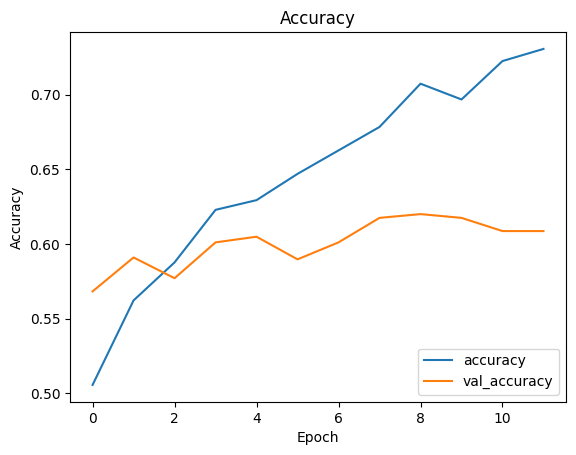

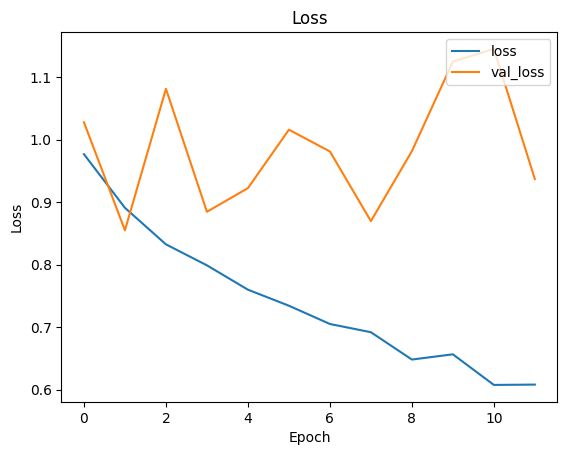

1/1 [==============================] - 2s 2s/step


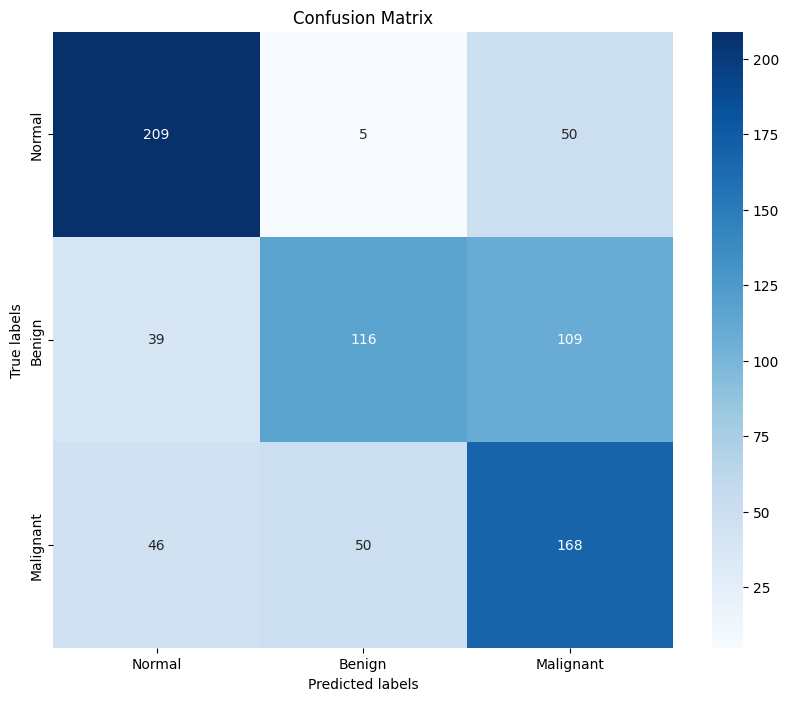

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       264
           1       0.68      0.44      0.53       264
           2       0.51      0.64      0.57       264

    accuracy                           0.62       792
   macro avg       0.63      0.62      0.62       792
weighted avg       0.63      0.62      0.62       792

25/25 [==============================] - 2s 80ms/step - loss: 0.8109 - accuracy: 0.6225
Pèrdua en el conjunt de dades de test: 0.8109254837036133
Precisió en el conjunt de dades de test: 0.622474730014801


In [46]:
custom_model3.full_report(model=model_retrained_effic1, history=history10)

## 3.5. Descongelem els dos últims blocs

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_effic_2.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-3)

model_retrained_effic2 = custom_model3.freeze_layers(model_initial=model_effic, num_layers_to_freeze = 234)

history11 = custom_model3.train(model=model_retrained_effic2, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])

custom_model3.show_layers(model_retrained_effic2.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.9487 - accuracy: 0.5272
Epoch 1: val_loss improved from inf to 1.01599, saving model to /content/drive/My Drive/model_effic_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 64s 371ms/step - loss: 0.9487 - accuracy: 0.5272 - val_loss: 1.0160 - val_accuracy: 0.5088
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.8847 - accuracy: 0.5692
Epoch 2: val_loss improved from 1.01599 to 0.88213, saving model to /content/drive/My Drive/model_effic_2.h5
116/116 [==============================] - 22s 193ms/step - loss: 0.8847 - accuracy: 0.5692 - val_loss: 0.8821 - val_accuracy: 0.5922
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.5995
Epoch 3: val_loss did not improve from 0.88213
116/116 [==============================] - 18s 158ms/step - loss: 0.8235 - accuracy: 0.5995 - val_loss: 1.1988 - val_accuracy: 0.5997
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.6011
Epoch 4: val_loss did not improve from 0.88213
116/116 [==============================] - 18s 158ms/step - loss: 0.8222 - accuracy: 0.6011 - val_loss: 0.9

### Avaluem els resultats

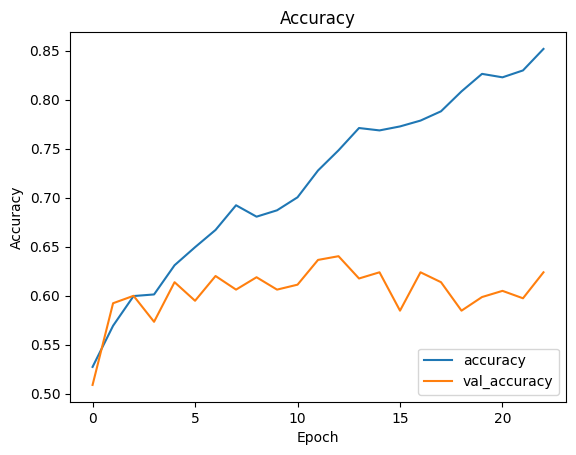

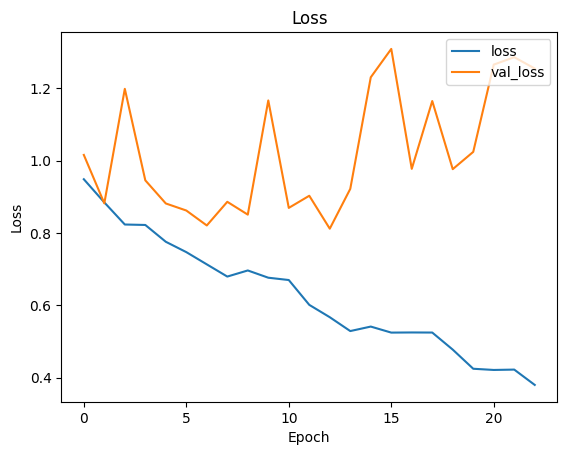

1/1 [==============================] - 2s 2s/step


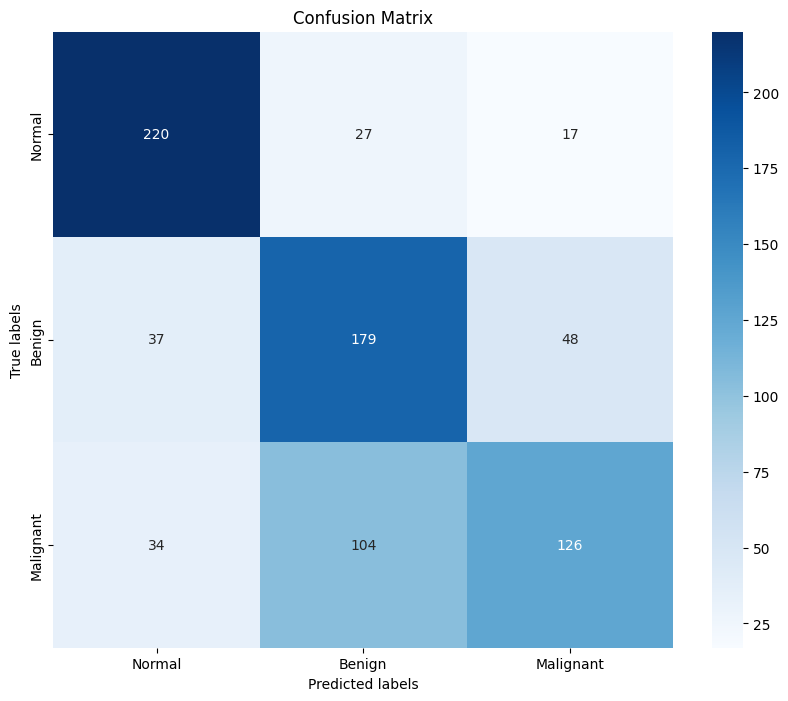

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       264
           1       0.58      0.68      0.62       264
           2       0.66      0.48      0.55       264

    accuracy                           0.66       792
   macro avg       0.66      0.66      0.66       792
weighted avg       0.66      0.66      0.66       792

25/25 [==============================] - 2s 81ms/step - loss: 0.7805 - accuracy: 0.6629
Pèrdua en el conjunt de dades de test: 0.7804993391036987
Precisió en el conjunt de dades de test: 0.6628788113594055


In [48]:
custom_model3.full_report(model=model_retrained_effic2, history=history11)

## 3.6. Descongelem tot el model

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(results_path + '/model_effic_3.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = Adam(learning_rate=1e-3)

model_retrained_effic3 = custom_model3.freeze_layers(model_initial=model_effic, num_layers_to_freeze = 1)

history12 = custom_model3.train(model=model_retrained_effic3, optimizer=optimizer, epochs = 50, callbacks=[early_stopping, checkpoint_callback])
custom_model3.show_layers(model_retrained_effic3.layers[2])

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.5797
Epoch 1: val_loss improved from inf to 0.90300, saving model to /content/drive/My Drive/model_effic_3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 123s 670ms/step - loss: 0.8983 - accuracy: 0.5797 - val_loss: 0.9030 - val_accuracy: 0.6010
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 0.8242 - accuracy: 0.6158
Epoch 2: val_loss did not improve from 0.90300
116/116 [==============================] - 47s 406ms/step - loss: 0.8242 - accuracy: 0.6158 - val_loss: 1.0003 - val_accuracy: 0.6199
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 0.8025 - accuracy: 0.6458
Epoch 3: val_loss improved from 0.90300 to 0.85734, saving model to /content/drive/My Drive/model_effic_3.h5
116/116 [==============================] - 51s 439ms/step - loss: 0.8025 - accuracy: 0.6458 - val_loss: 0.8573 - val_accuracy: 0.6376
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.6618
Epoch 4: val_loss improved from 0.85734 to 0.84590, saving model to /content/drive/My Drive/model_effic_3.h5
116/116 [==============================] - 5

### Avaluem els resultats

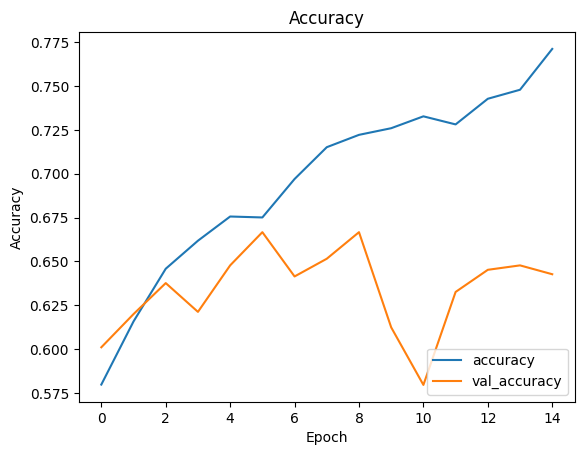

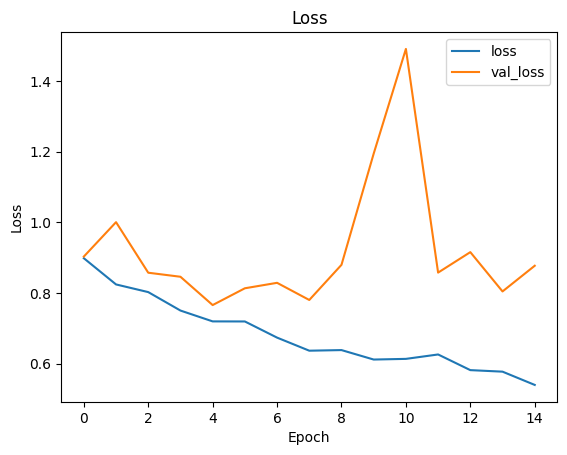

1/1 [==============================] - 2s 2s/step


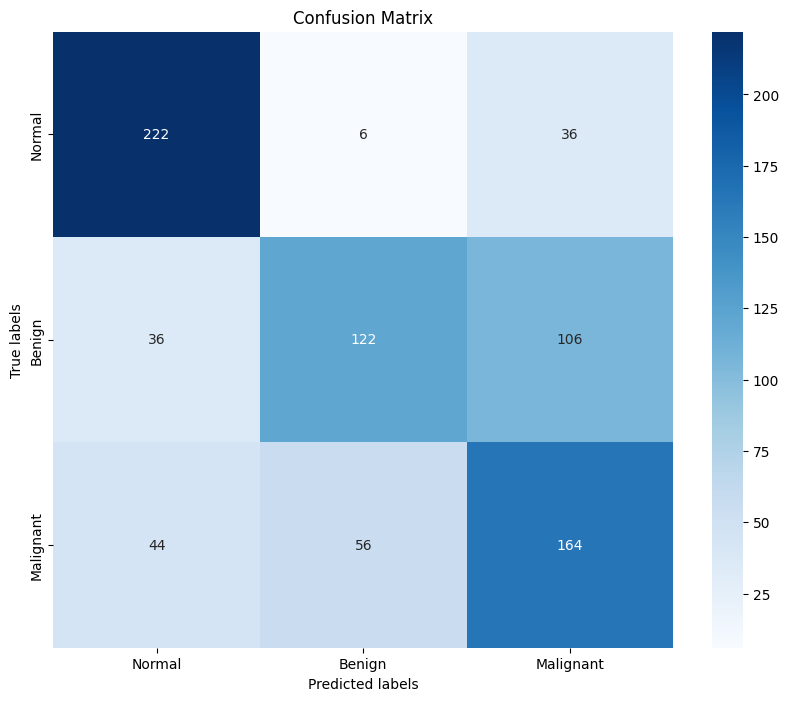

              precision    recall  f1-score   support

           0       0.74      0.84      0.78       264
           1       0.66      0.46      0.54       264
           2       0.54      0.62      0.58       264

    accuracy                           0.64       792
   macro avg       0.64      0.64      0.63       792
weighted avg       0.64      0.64      0.63       792

25/25 [==============================] - 2s 80ms/step - loss: 0.7878 - accuracy: 0.6414
Pèrdua en el conjunt de dades de test: 0.7877961993217468
Precisió en el conjunt de dades de test: 0.6414141654968262


In [50]:
custom_model3.full_report(model=model_retrained_effic3, history=history12)

# 5. Comprovem quines imatges s'han classificat incorrectament

### Utilitzarem el model efficientnet que és el que hem obtingut millors mètriques

In [9]:
model_retrained_effic1 = load_model('/content/drive/MyDrive/model_effic_2.h5')

1/1 [==============================] - 0s 29ms/step


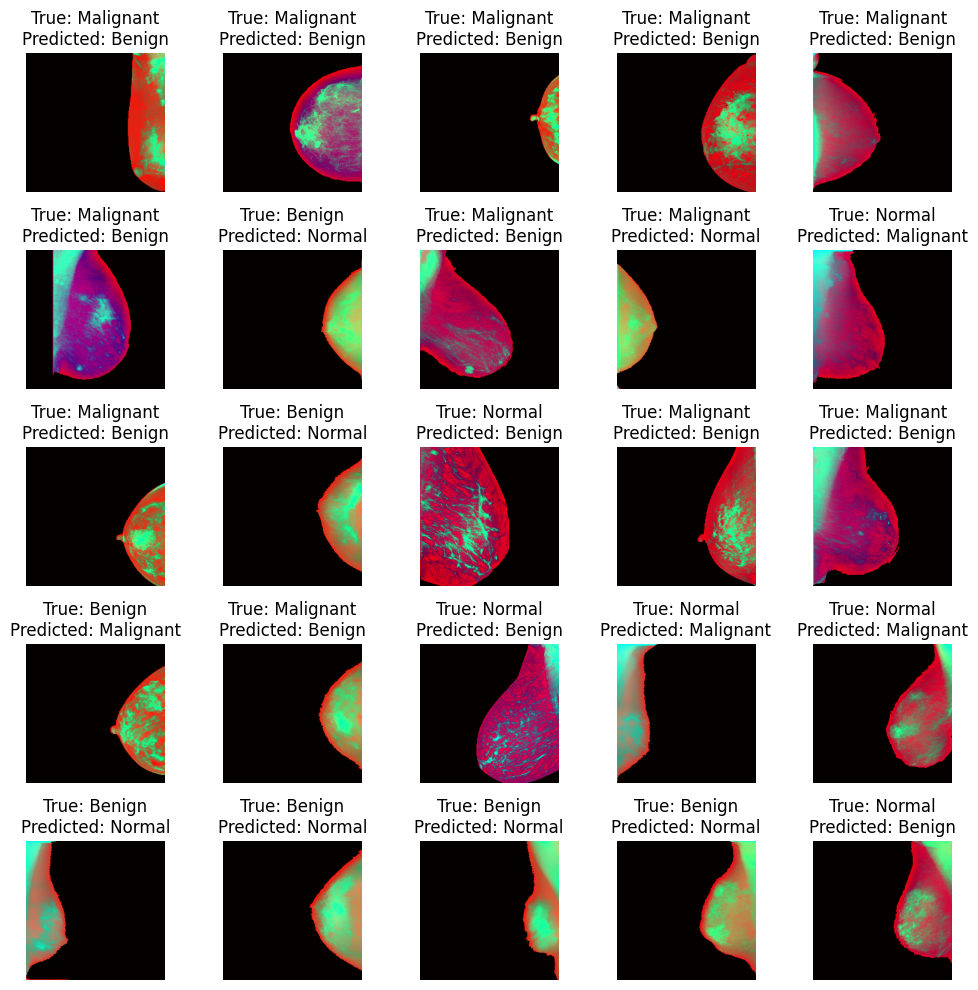

ACR Stats:
ACR
Unknown    0.300310
B          0.367876
C          0.404412
A          0.394737
D          0.218750
Name: count, dtype: float64

Dataset Stats:
Database
DDSM        0.369615
CMMD        0.257261
CESM        0.421687
MIAS        0.250000
INbreast    0.285714
Name: count, dtype: float64

Mass shape:
Mass_shape
0                     NaN
Circumscribed    0.561644
Indistinct       0.596774
Lobulated        0.538462
Obscured         0.615385
Speculated       0.507463
Unknown          0.262097
Name: count, dtype: float64


<ipython-input-28-3c918eca9d45>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['Predicted Label'] = predicted_labels_valid


In [28]:
def predicted_images(model, test_ds):
    """
    Avalua un model utilitzant un conjunt de dades de prova i retorna les prediccions, les etiquetes reals i les imatges.

    Args:
    - model: Model a avaluar.
    - test_ds: Conjunt de dades de prova.

    Returns:
    - y_true: Etiquetes reals del conjunt de dades de prova.
    - y_pred: Prediccions del model.
    - images_array: Array que conté les imatges utilitzades per a la predicció.
    """
    y_true = []
    y_pred = []
    images_array = []

    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        images_array.extend(images.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    images_array = np.array(images_array)

    return y_true, y_pred, images_array


y_true, y_pred, images_array = predicted_images(model_retrained_effic1, test_ds)

class_names = ['Normal', 'Benign', 'Malignant']
misclassified_images = []
misclassified_indices = []

for i in range(len(y_true)):
    if y_pred[i] != y_true[i]:
        misclassified_images.append(images_array[i])
        misclassified_indices.append(i)

plt.figure(figsize=(10, 10))
for i, index in enumerate(misclassified_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images_array[index])
    plt.title(f"True: {class_names[y_true[index]]}\nPredicted: {class_names[y_pred[index]]}")
    plt.axis('off')


plt.tight_layout()
plt.show()

test_df = pd.read_csv("/content/drive/MyDrive/test.csv")

misclassified_df = test_df.iloc[misclassified_indices]

predicted_labels_valid = []

for index, row in misclassified_df.iterrows():
    if index in misclassified_indices:
        predicted_labels_valid.append(class_names[y_pred[index]])
    else:
        predicted_labels_valid.append(None)

misclassified_df['Predicted Label'] = predicted_labels_valid

acr_relative_freq = misclassified_df['ACR'].value_counts() / test_df['ACR'].value_counts()

dataset_relative_freq = misclassified_df['Database'].value_counts() / test_df['Database'].value_counts()

misclassified_df2 = misclassified_df[misclassified_df['Label'] != 0 ]

shape_relative_freq = misclassified_df2['Mass_shape'].value_counts() / test_df['Mass_shape'].value_counts()


print("ACR Stats:")
print(acr_relative_freq)
print("\nDataset Stats:")
print(dataset_relative_freq)
print("\nMass shape:")
print(shape_relative_freq)




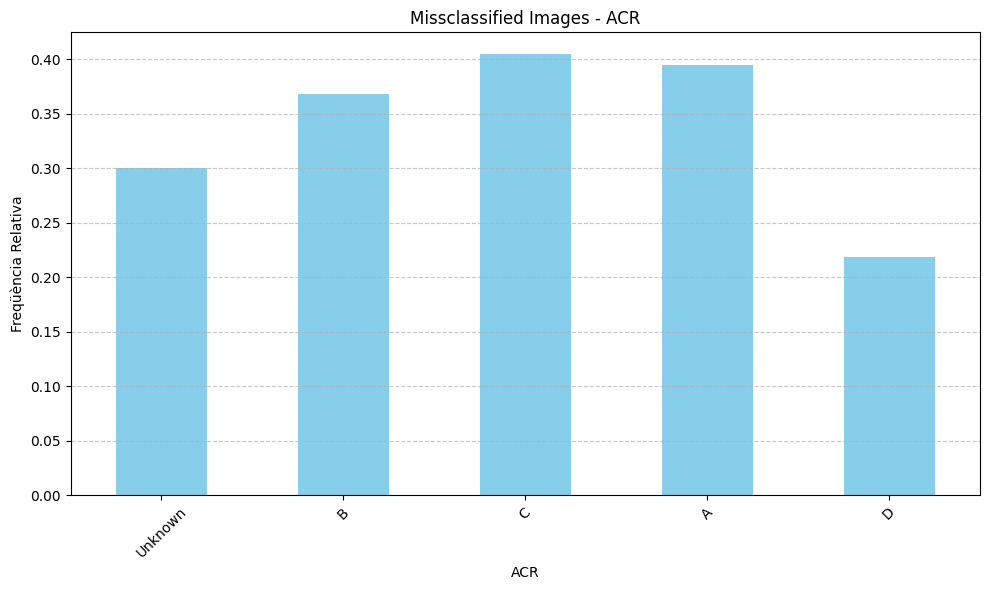

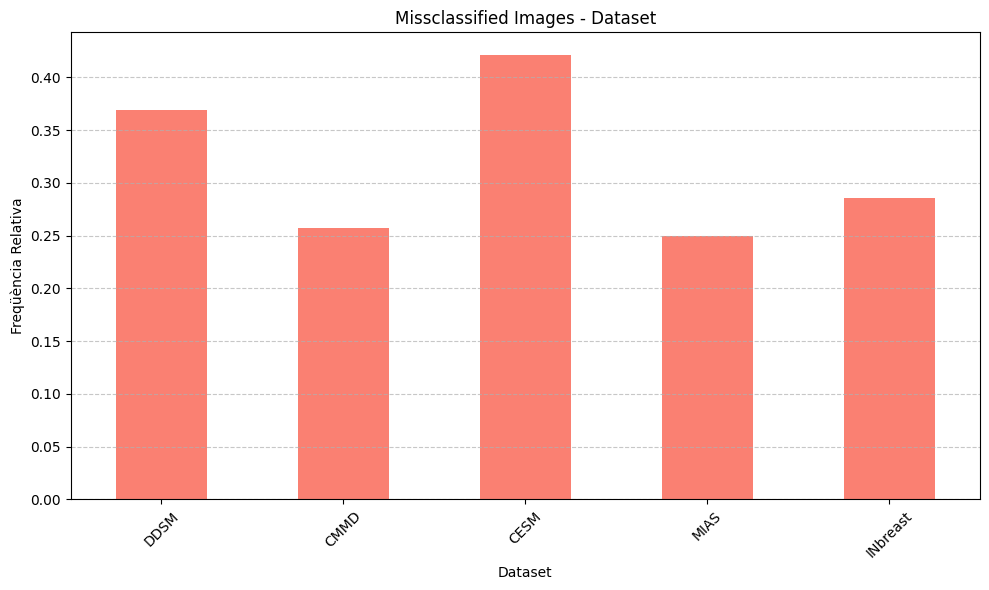

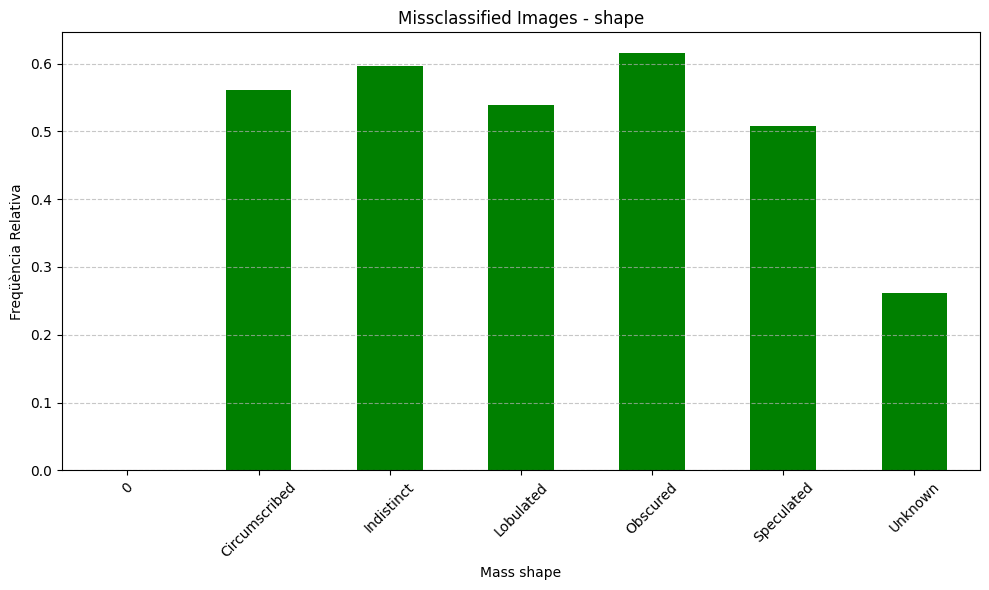

In [29]:
plt.figure(figsize=(10, 6))
acr_relative_freq.plot(kind='bar', color='skyblue')
plt.title('Missclassified Images - ACR')
plt.xlabel('ACR')
plt.ylabel('Freqüència Relativa')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
dataset_relative_freq.plot(kind='bar', color='salmon')
plt.title('Missclassified Images - Dataset')
plt.xlabel('Dataset')
plt.ylabel('Freqüència Relativa')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shape_relative_freq.plot(kind='bar', color='green')
plt.title('Missclassified Images - shape')
plt.xlabel('Mass shape')
plt.ylabel('Freqüència Relativa')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()